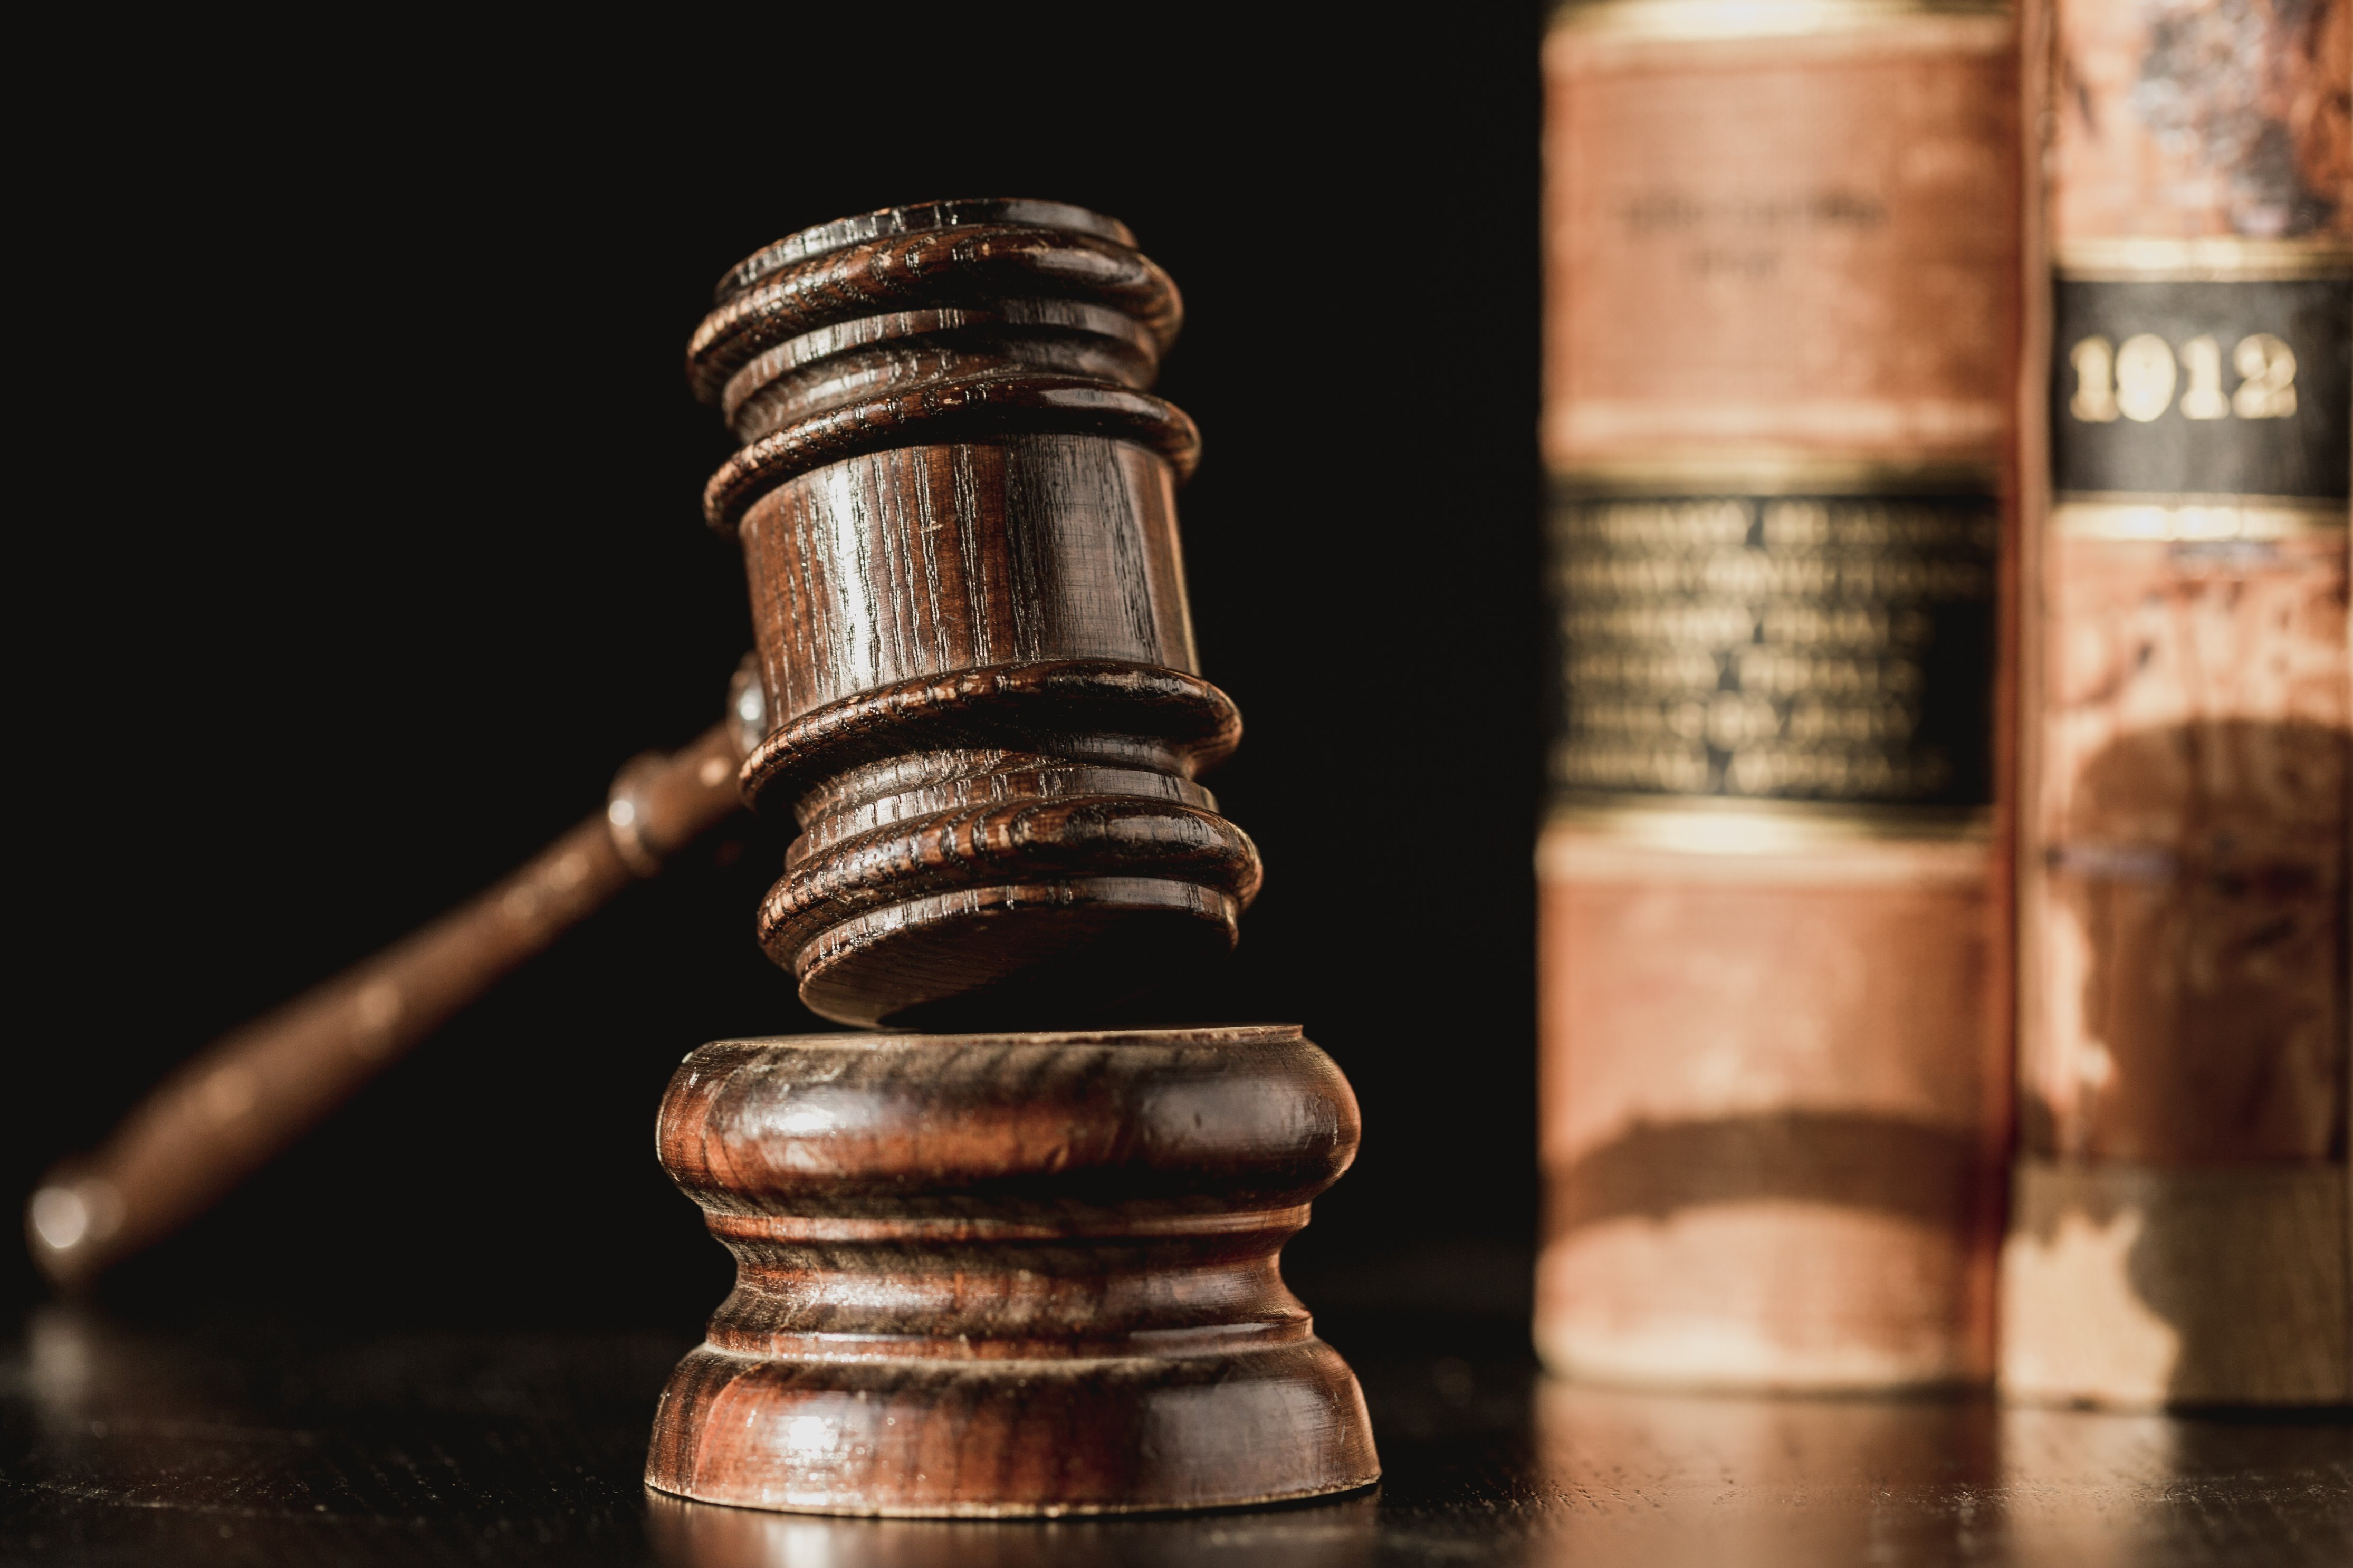

# Predicting Fine Collection Outcome for Low-Level Civil Tickets Issued in New York City

### October 2021
### Allison Gao

This analysis used data on low-level civil tickets issued by public agencies in New York City to predict fine collection outcomes. This is a binary problem where a ticket either did or did not result in a fine collected.

The purpose of the analysis is to create a classification model that predicts whether or not a ticket will result in fine collection. When a ticket is issued to an individual or a commercial entity, the outcome falls into one of the four categories: 

               1) ticket is written off before a hearing takes place
               2) case dismissed
               3) guilty
               4) defaulted, commonly known as no action by the respondent. 


Scenarios 3 and 4 result in fine collection while the first and the second outcome do not.


According to a study published in the Yale Law Journal(insert link here), just slightly more than half of the tickets adjudicated by the City’s civil court resulted in fine collection. This raises a series of policy implications. 

1.  Fines and fees are an income stream for the City of New York. An incorrect estimate can lead to problematic budget analysis. Therefore, this project seeks to produce a model that accurately predicts if a ticket will end up in fine collection. 

2. If fine collection serves to deter bad behavior, but a significant number of tickets do not result in fine collection, then it raises questions on its intentions. As such, this project also aims to highlight features relevant to the predictive class. 

Findings from this project are applicable to a range of stakeholders. This includes the City of New York, elected officials, as well as public affairs firms seeking to evaluate the City's fine collection policy. 


#### Key Metrics for Model Evaluation: Precision

I am mainly concerned with precision because I want my model to accurately predict the positive group, which is the fine collected group. In other words, I want to minimize my model predicting false positives. A false positive prediction happens when my model predicts fine collected for a ticket when in actuality the ticket does not end in fine. Such incorrect prediction will lead to an overestimation of fine collected. 


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Part 1
Import raw data and conduct first round of data cleaning. The entire dataset contains 17.9 million rows. 
Only imported data where the column "Issuing Agency" contains the word "police."

In [606]:
df = pd.read_csv("pol_only.csv", low_memory = False)

In [607]:
df.head(5)

,Ticket Number,Violation Date,Violation Time,Issuing Agency,Respondent First Name,Respondent Last Name,Balance Due,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (Floor),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Hearing Status,Hearing Result,Scheduled Hearing Location,Hearing Date,Hearing Time,Decision Location (Borough),Decision Date,Total Violation Amount,Violation Details,Date Judgment Docketed,Respondent Address or Facility Number(For FDNY and DOB Tickets),Penalty Imposed,Paid Amount,Additional Penalties or Late Fees,Compliance Status,Violation Description,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,Charge #4: Code,Charge #4: Code Section,Charge #4: Code Description,Charge #4: Infraction Amount,Charge #5: Code,Charge #5: Code Section,Charge #5: Code Description,Charge #5: Infraction Amount,Charge #6: Code,Charge #6: Code Section,Charge #6: Code Description,Charge #6: Infraction Amount,Charge #7: Code,Charge #7: Code Section,Charge #7: Code Description,Charge #7: Infraction Amount,Charge #8: Code,Charge #8: Code Section,Charge #8: Code Description,Charge #8: Infraction Amount,Charge #9: Code,Charge #9: Code Section,Charge #9: Code Description,Charge #9: Infraction Amount,Charge #10: Code,Charge #10: Code Section,Charge #10: Code Description,Charge #10: Infraction Amount
0,0198948842,02/13/2020,03:15:00,POLICE DEPARTMENT,JUAN,FLORES,112.0,QUEENS,1769.0,55.0,103-19,39 AVENUE,NaN,CORONA,11368,NEW YORK,NOT NYC,35-30,91 ST,NaN,NaN,NaN,DOCKETED,DEFAULTED,NaN,08/05/2020,10:30:00,NaN,08/12/2020,75.0,20200401N,11/30/2020,BSMT,112.0,0.0,0.0,Penalty Due,NaN,AS9I,16-118 6,PUBLIC URINATION 1ST OFFENSE,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0198984253,02/12/2020,22:45:00,POLICE DEPARTMENT,ERIC A,NICASIO,112.0,QUEENS,NaN,NaN,NaN,CORONA AVE JUNCTION BLVD,NaN,QUEENS,NaN,NEW YORK,NOT NYC,237,111 ST,NaN,NaN,NaN,DOCKETED,DEFAULTED,NaN,08/05/2020,10:30:00,NaN,08/12/2020,75.0,20200401N,11/30/2020,NaN,112.0,0.0,0.0,Penalty Due,NaN,AS9I,16-118 6,PUBLIC URINATION 1ST OFFENSE,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0199274121,02/10/2020,23:15:00,POLICE DEPARTMENT,ELIAS,SULUSA,25.0,QUEENS,1482.0,11.0,94-18,37 AVENUE,NaN,JACKSON HEIGHTS,11372,NEW YORK,NOT NYC,34-36,90 ST,NaN,NaN,NaN,DEFAULTED,DEFAULTED,NaN,07/15/2020,08:30:00,NaN,07/22/2020,25.0,20200327N,09/21/2020,NaN,25.0,0.0,0.0,Penalty Due,NaN,AX25,AC 10-125,OPEN CONTAINER CONSUMPTION OF ALCOHOL ON STREETS,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0199009773,02/11/2020,19:33:00,POLICE DEPARTMENT,YOON S,CHO,0.0,QUEENS,NaN,NaN,NaN,C O NORTHERN BLVD FRANCIS LE,NaN,QUEENS,NaN,NEW YORK,QUEENS,58-60,207 STREET,OAKLAND GARDENS,11364,NEW YORK,PAID IN FULL,NaN,NaN,03/30/2020,10:30:00,NaN,NaN,250.0,20200330N,NaN,NaN,250.0,250.0,0.0,All Terms Met,NaN,AD6L,AC 19-190 B,"RIGHT OF WAY - FAILURE TO YIELD, PHYSICAL INJURY",250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0199417525,12/30/2019,17:25:00,POLICE DEPARTMENT,STAVROULA,KOKKOROS,0.0,QUEENS,NaN,NaN,NaN,151 AVENUE 84 STREET,NaN,QUEENS,NaN,NEW YOR

In [608]:
df.shape

(766394, 78)

In [609]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766394 entries, 0 to 766393
Data columns (total 78 columns):
 #   Column                                                           Non-Null Count   Dtype  
---  ------                                                           --------------   -----  
 0   Ticket Number                                                    766394 non-null  object 
 1   Violation Date                                                   763596 non-null  object 
 2   Violation Time                                                   764415 non-null  object 
 3   Issuing Agency                                                   766394 non-null  object 
 4   Respondent First Name                                            498874 non-null  object 
 5   Respondent Last Name                                             762112 non-null  object 
 6   Balance Due                                                      313916 non-null  float64
 7   Violation Location (Borough) 

### Identify the predictive class "Hearing Result", drop nulls from the column and rename the values. 

In [610]:
# drop all nulls
df.dropna(subset=["Hearing Result"], inplace=True)

In [611]:
#since the final outcome of the predictive class is "fine collected" versus "no fine collected", need to drop tickets where they don't need to either of these two outcomes.
df = df.loc[(df["Hearing Result"] != "NONE") & (df["Hearing Result"] != "ADJOURNED") & (df["Hearing Result"] != "STIPULATED")]

In [612]:
df["Hearing Result"].replace({ "WRITTEN OFF": "NO FINE COLLECTED",
                               "DEFAULTED": "FINE COLLECTED",
                               "DISMISSED": "NO FINE COLLECTED",
                               "IN VIOLATION": "FINE COLLECTED",
                               "DEFAULT": "FINE COLLECTED",
                               "SETTL IN-VIO": "NO FINE COLLECTED",
                               "COSRV INVIO": "NO FINE COLLECTED",
                               "POP IN-VIOL": "NO FINE COLLECTED",
                               "POP/IN-VIOL": "NO FINE COLLECTED"
                             
                             
                             }, inplace=True)

In [613]:
#even though they are different, each of these end up in either fine collected or no fine collected
df["Hearing Result"].value_counts()

NO FINE COLLECTED    384229
FINE COLLECTED       227082
Name: Hearing Result, dtype: int64

In [614]:
#relabel it into 0 or 1 class to help with modeling later
df['Hearing Result'] = df['Hearing Result'].map({'NO FINE COLLECTED': 0,
                                     'FINE COLLECTED': 1})

In [615]:
df["Hearing Result"].value_counts(normalize=True)

0    0.628533
1    0.371467
Name: Hearing Result, dtype: float64

### EDA and Clean Columns

Only want to focus on respondents whose address is in New York City because this dataframe will be merged with neighborhood-level data later on.

In [616]:
df["Respondent Address (State Name)"].value_counts()

NEW YORK               568515
NEW JERSEY              20209
PENNSYLVANIA             1194
FLORIDA                   920
CONNECTICUT               694
MASSACHUSETTS             537
NORTH CAROLINA            358
VIRGINIA                  281
MARYLAND                  280
CALIFORNIA                238
GEORGIA                   178
ILLINOIS                  177
SOUTH CAROLINA            163
WASHINGTON                144
TEXAS                     138
MISSOURI                  111
OHIO                      108
RHODE ISLAND              107
MICHIGAN                  101
OTHER                      56
DELAWARE                   54
TENNESSEE                  45
OKLAHOMA                   42
ALABAMA                    40
LOUISIANA                  36
DIST COLUMBIA              34
NEBRASKA                   31
ARIZONA                    29
COLORADO                   28
MAINE                      25
OREGON                     23
INDIANA                    21
KENTUCKY                   20
WISCONSIN 

In [617]:
df = df.loc[(df["Respondent Address (State Name)"] == "NEW YORK")]

### Drop columns that contain all null values
The raw dataset has several empty columns. 

In [618]:
column_list = list(df.columns)

In [619]:
empty_columns = []

for x in column_list:

    if df[x].isnull().all() == True:
        empty_columns.append(x)

df.drop(empty_columns, axis = 1, inplace=True)

In [620]:
empty_columns

['Violation Location (Floor)',
 'Violation Description',
 'Charge #4: Code',
 'Charge #4: Code Section',
 'Charge #4: Code Description',
 'Charge #4: Infraction Amount',
 'Charge #5: Code',
 'Charge #5: Code Section',
 'Charge #5: Code Description',
 'Charge #5: Infraction Amount',
 'Charge #6: Code',
 'Charge #6: Code Section',
 'Charge #6: Code Description',
 'Charge #6: Infraction Amount',
 'Charge #7: Code',
 'Charge #7: Code Section',
 'Charge #7: Code Description',
 'Charge #7: Infraction Amount',
 'Charge #8: Code',
 'Charge #8: Code Section',
 'Charge #8: Code Description',
 'Charge #8: Infraction Amount',
 'Charge #9: Code',
 'Charge #9: Code Section',
 'Charge #9: Code Description',
 'Charge #9: Infraction Amount',
 'Charge #10: Code',
 'Charge #10: Code Section',
 'Charge #10: Code Description',
 'Charge #10: Infraction Amount']

In [621]:
df.shape

(568515, 48)

In [622]:
df.columns

Index(['Ticket Number', 'Violation Date', 'Violation Time', 'Issuing Agency',
       'Respondent First Name', 'Respondent Last Name', 'Balance Due',
       'Violation Location (Borough)', 'Violation Location (Block No.)',
       'Violation Location (Lot No.)', 'Violation Location (House #)',
       'Violation Location (Street Name)', 'Violation Location (City)',
       'Violation Location (Zip Code)', 'Violation Location (State Name)',
       'Respondent Address (Borough)', 'Respondent Address (House #)',
       'Respondent Address (Street Name)', 'Respondent Address (City)',
       'Respondent Address (Zip Code)', 'Respondent Address (State Name)',
       'Hearing Status', 'Hearing Result', 'Scheduled Hearing Location',
       'Hearing Date', 'Hearing Time', 'Decision Location (Borough)',
       'Decision Date', 'Total Violation Amount', 'Violation Details',
       'Date Judgment Docketed',
       'Respondent Address or Facility Number(For FDNY and DOB Tickets)',
       'Penalty Impos

In [623]:
#drop additional columns that are not useful for the analysis 

columns_to_drop = ['Violation Time','Balance Due',
       'Hearing Status','Scheduled Hearing Location',
       'Hearing Date', 'Hearing Time',
       'Decision Date', 'Total Violation Amount', 'Violation Details',
       'Date Judgment Docketed',
       'Respondent Address or Facility Number(For FDNY and DOB Tickets)',
        'Additional Penalties or Late Fees',
       'Compliance Status']

df.drop(columns_to_drop, axis = 1, inplace=True)
df.shape

(568515, 35)

### Create a violation location and respondent's address column
The current dataset has each component of the address in its own column. Having a single column dedicated to a complete address will help see the info better and quicker.

In [624]:
# zip code is an important piece of information in address identification. 
df.dropna(subset=["Violation Location (Zip Code)"], inplace=True)
df.dropna(subset=["Respondent Address (Zip Code)"], inplace=True)

In [628]:
# get a complete address for where the violation took place
viol_cols = ['Violation Location (Borough)', 'Violation Location (Block No.)',
       'Violation Location (Lot No.)', 'Violation Location (House #)',
       'Violation Location (Street Name)',
       'Violation Location (City)', 'Violation Location (Zip Code)',
       'Violation Location (State Name)']

# get a complete address for where the respondent lives
resp_cols = ['Respondent Address (Borough)',
       'Respondent Address (House #)', 'Respondent Address (Street Name)',
       'Respondent Address (City)', 'Respondent Address (Zip Code)',
       'Respondent Address (State Name)']



df['complete violation location'] = df[viol_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['complete violation location'] = df['complete violation location'].map(lambda x: x.replace("nan", ''))


df['complete respondent location'] = df[resp_cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['complete respondent location'] = df['complete respondent location'].map(lambda x: x.replace("nan", ''))

In [626]:
print("Violation Location (Zip Code) has {} nulls".format(df['Violation Location (Zip Code)'].isnull().sum()))
print("Respondent Address (Zip Code) has {} nulls".format(df['Respondent Address (Zip Code)'].isnull().sum()))

Violation Location (Zip Code) has 0 nulls
Respondent Address (Zip Code) has 0 nulls


In [627]:
df["complete violation location"].isnull().sum()

0

# With a cleaned dataframe, split the dataset into train and test set. 
To prevent data leakage, will save the train and test into separate csv files, and not touch the testing until it is ready for final model evaluation.

In [629]:
X = df.drop('Hearing Result', axis=1)
y = df["Hearing Result"]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=42,
                                                    stratify=y)

In [631]:
#make sure this is split correctly
y_train.value_counts(normalize=True)

0    0.604015
1    0.395985
Name: Hearing Result, dtype: float64

In [632]:
#bring the two dfs back
df_train=pd.concat([X_train, y_train], axis=1)
df_test=pd.concat([X_test, y_test], axis=1)

In [633]:
df_train.head(1)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Paid Amount,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result
712058,046743019Y,04/11/2019,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,LONG ISLA,0.0,0.0,AS06,A.C. 16-118 2 A,DIRTY SIDEWALK DIRTY AREA,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,0


In [635]:
# save them into two different csv files
df_train.to_csv('df_train.csv')
df_test.to_csv('df_test.csv')

# Part 2
Focus on cleaning the training set and feature enginnering it to get ready for modeling.

In [636]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
import random
from os import path
from PIL import Image
from nltk import word_tokenize, pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, TweetTokenizer, word_tokenize
from wordcloud import WordCloud
import os

In [637]:
df = pd.read_csv("df_train.csv", low_memory = False)
df['Respondent Address (Zip Code)'] = df['Respondent Address (Zip Code)'].astype(str)
#paid amount is not needed b/c this is when someone is already found in violation; it directly correlates with fine collected
df = df.drop(["Paid Amount","Unnamed: 0"], axis = 1)

In [638]:
df["Hearing Result"].value_counts(normalize=True)
#zero means no fee collected
# one means fee collected

0    0.604015
1    0.395985
Name: Hearing Result, dtype: float64

### Create a column on weekend versus weekday 

In [477]:
#convert datetime first
df["Violation Date"] = pd.to_datetime(df["Violation Date"])

#pull out weekday
df['WEEKDAY'] = pd.to_datetime(df["Violation Date"]).dt.dayofweek

df['weekend_indi'] = 0    
df.loc[df['WEEKDAY'].isin([5, 6]), 'weekend_indi'] = 1 

#1 means weekend and 0 means weekday
print(df["weekend_indi"].value_counts())
df['weekend_indi'].fillna('UNKNOWN', inplace=True)

0    162332
1     50911
Name: weekend_indi, dtype: int64


### Create a column on season

In [478]:
df['month'] = pd.DatetimeIndex(df['Violation Date']).month

df['Season'] = df['month'].map({1.0: "Winter",
                                      2.0: 'Winter',
                                      3.0: "Spring",
                                      4.0: "Spring",
                                      5.0: "Spring",
                                      6.0: "Summer",
                                      7.0: "Summer",
                                      8.0: "Summer",
                                      9.0: "Fall",
                                      10.0: "Fall",
                                      11.0: "Fall",
                                      12.0: "Winter"
                                     })

df['Season'].value_counts()
df['Season'].fillna('UNKNOWN', inplace=True)

### Regroup issuing agency column to make it cleaner

In [479]:
df["Issuing Agency"].value_counts()

SANITATION POLICE                 122071
POLICE DEPARTMENT                  69343
NYPD TRANSPORT INTELLIGENCE DI     10449
POLICE DEPT                         9581
SANITATION ENVIRON. POLICE          1015
SEAGATE POLICE                       570
DEP. POLICE                          214
Name: Issuing Agency, dtype: int64

In [480]:
df['Issuing Agency'] = df['Issuing Agency'].map({"SANITATION POLICE": "SANITATION POLICE",
                                      "POLICE DEPARTMENT": 'NYPD',
                                      "NYPD TRANSPORT INTELLIGENCE DI": "NYPD TRANSPORT INTELLIGENCE DI",
                                      "POLICE DEPT ": "NYPD",
                                      "SANITATION ENVIRON. POLICE": "SANITATION POLICE",
                                      "SEAGATE POLICE": "NYPD (SEAGATE)",
                                      "DEP. POLICE ": "NYPD"})

df['Issuing Agency'].fillna('UNKNOWN', inplace=True)

In [481]:
df['Issuing Agency'].value_counts()

SANITATION POLICE                 123086
NYPD                               69343
NYPD TRANSPORT INTELLIGENCE DI     10449
UNKNOWN                             9795
NYPD (SEAGATE)                       570
Name: Issuing Agency, dtype: int64

### Regroup decision location/method column to make it cleaner

In [482]:
df['Decision Location (Borough)'] = df['Decision Location (Borough)'].map(
                                     {'UNKNOWN': "UNKNOWN",
                                      'MANHATTAN': 'In Person MANHATTAN',
                                      'BROOKLYN': "In Person BROOKLYN",
                                      'QUEENS': "In Person QUEENS",
                                      'BRONX': "In Person BRONX",
                                      'SAU: MANH': "Remote",
                                      'BY PHONE': "Remote",
                                      'STATEN IS': "In Person STATEN IS",
                                     'LONG ISLA': "In Person QUEENS",
                                     'SAU: BX': "Remote",
                                     'SAU: BKLN': "Remote",
                                     'SAU: LIC': "Remote",
                                     'ONE-CLICK': "Remote"
                                     })

In [483]:
df['Decision Location (Borough)'].value_counts()

In Person MANHATTAN    32739
In Person BROOKLYN      8600
In Person QUEENS        6814
Remote                  6691
In Person BRONX         4838
In Person STATEN IS     1021
Name: Decision Location (Borough), dtype: int64

### Penalty Imposed Column

In [484]:
df["Penalty Imposed"] = df["Penalty Imposed"].astype("float64")
df['Penalty Imposed'].fillna(df['Penalty Imposed'].mean(), inplace=True)

### Infraction Column
This column contains information on the section of the law cited on the ticket. 
Without standardization, it is difficult to see its distribution. Once standardized, it can be used for one hot encoding and visualization

In [590]:
pd.options.display.max_colwidth = 1000000
pd.set_option('display.max_columns', 2000000000)

df.loc[df['Charge #1: Code Section'] =="A.C. 20-463", 'Charge #1: Code Description'].head(5)

3235    FAILURE TO KEEP OR PRODUCE REQUIRED WRITTEN RECORDS
3259    FAILURE TO KEEP OR PRODUCE REQUIRED WRITTEN RECORDS
6352    FAILURE TO KEEP OR PRODUCE REQUIRED WRITTEN RECORDS
7803    FAILURE TO KEEP OR PRODUCE REQUIRED WRITTEN RECORDS
9585    FAILURE TO KEEP OR PRODUCE REQUIRED WRITTEN RECORDS
Name: Charge #1: Code Description, dtype: object

In [ ]:
df['Charge #1: Code Section'].fillna('UNKNOWN', inplace=True)

In [486]:
df['Charge #1: Code Section'] = df['Charge #1: Code Section'].map(
{"15 RCNY 19-02 E": "15 RCNY 19", '15 RCNY 19-02(A-D)': "15 RCNY 19",'15 RCNY 19-02(A),(D)': "15 RCNY 19",
'15 RCNY 19-03 F':"15 RCNY 19",'15 RCNY 19-03(A)(5)-(8)':"15 RCNY 19",'15 RCNY 19-03(B)':"15 RCNY 19",
'15 RCNY 19-03(D)(2)':"15 RCNY 19",'15 RCNY 19-04 A - C':"15 RCNY 19",'15 RCNY 19-04 A-C':"15 RCNY 19",
 '15 RCNY 19-04(A-C)':"15 RCNY 19",'15 RCNY 19-04(E)':"15 RCNY 19",'15 RCNY 19-05 C':"15 RCNY 19",
 '15 RCNY 19-05 E':"15 RCNY 19",'15 RCNY 19-05(C)':"15 RCNY 19",
'15 RCNY 19-06 A':"15 RCNY 19",
'15 RCNY 19-06 B':"15 RCNY 19",
'15 RCNY 19-06(A)':"15 RCNY 19",
'15 RCNY 19-10 C - E':"15 RCNY 19",
'15 RCNY 19-10(B,C)':"15 RCNY 19",
'15 RCNY19-02 A,D': "15 RCNY 19",
'15RCNY19-02 A , D': "15 RCNY 19",                                     
'15 RCNY 20-01 E':"15 RCNY 20",
'15 RCNY 20-04 D':"15 RCNY 20",
'15 RCNY 20-04 E':"15 RCNY 20",
'15 RCNY 20-05 A':"15 RCNY 20",
'15 RCNY 20-05 B 2':"15 RCNY 20",
'15 RCNY 20-05 D 5':"15 RCNY 20",
'15 RCNY 20-05 I 2-11':"15 RCNY 20",
'15 RCNY 20-05(D)(5)':"15 RCNY 20",
'15 RCNY 20-06 E':"15 RCNY 20", 
'15 RCNY CHAP. 20':"15 RCNY 20",     
'15 RCNY 21-03 H':"15 RCNY 21",
'15 RCNY 21-03(H)':"15 RCNY 21",
'15 RCNY 21-03(I)':"15 RCNY 21",
'15 RCNY 21-06':"15 RCNY 21",
'15 RCNY 21-10 B':"15 RCNY 21",      
'16 RCNY 1-08 H 4':"16 RCNY",
'16 RCNY 1-08 H 5':"16 RCNY",
'16 RCNY 1-08(H)(4)':"16 RCNY",
'16 RCNY 1-08(H)(5)':"16 RCNY",
'16 RCNY 4-04 ET SEQ.':"16 RCNY",
'16 RCNY 4-11 ET SEQ.':"16 RCNY",
'16 RCNY 8-03 A 1':"16 RCNY",
'16 RCNY 8-03 A 2':"16 RCNY",
'16 RCNY 8-03 A 3':"16 RCNY",
'16 RCNY 8-04 A 1':"16 RCNY",
'16 RCNY 8-04 A 4':"16 RCNY",
'16 RCNY 8-04 A 5':"16 RCNY",
'16 RCNY 8-04(A)(1)':"16 RCNY",
'16 RCNY 8-04(A)(3)':"16 RCNY",
'16 RCNY 8-05 A':"16 RCNY",
'16 RCNY 8-05 C':"16 RCNY",
'16 RCNY 8-05(C)':"16 RCNY",
'16 RCNY 8-06 A':"16 RCNY",                              
'16RCNY 1-08 E 1 , 2':"16 RCNY",
'16RCNY 1-08 E 3':"16 RCNY",
'16RCNY 1-08 F 1':"16 RCNY",
'16RCNY 1-08 F 2 I':"16 RCNY",
'16RCNY 1-08 F 2 III':"16 RCNY",
'16RCNY 1-08 G 1':"16 RCNY",
'16RCNY 1-08 G 2':"16 RCNY",
'16RCNY 1-08 G 3':"16 RCNY",
'16RCNY 1-08 H 1 , 2':"16 RCNY",
'16RCNY 1-08 H 4':"16 RCNY",
'16RCNY 1-08 H 5':"16 RCNY",
'16RCNY 1-08(E)(1),(2)':"16 RCNY",
'16RCNY 1-08(E)(3)':"16 RCNY",
'16RCNY 1-08(F)(1)':"16 RCNY",
'16RCNY 1-08(F)(2)(I)':"16 RCNY",
'16RCNY 1-08(F)(2)(III)':"16 RCNY",
'16RCNY 1-08(G)(1)':"16 RCNY",
'16RCNY 1-08(G)(2)':"16 RCNY",
'16RCNY 1-08(G)(3)':"16 RCNY",
'16RCNY 1-08(H)(1),(2)':"16 RCNY",
'16RCNY 1-08(H)(4)':"16 RCNY",
'16RCNY 1-08(H)(5)':"16 RCNY",
'16RCNY 1-10 C 1':"16 RCNY",
'16RCNY 1-10 C 2':"16 RCNY",
'16RCNY 1-10 D 2':"16 RCNY",
'16RCNY 1-10 F 1 I':"16 RCNY",
'16RCNY 1-10 F 1 II':"16 RCNY",
'16RCNY 1-10 F 1 III':"16 RCNY",
'16RCNY 1-10 F 1 IV':"16 RCNY",
'16RCNY 1-10 F 2 I':"16 RCNY",
'16RCNY 1-10 F 2 II,IV':"16 RCNY",
'16RCNY 1-10 G 3':"16 RCNY",
'16RCNY 1-10(C)(1)':"16 RCNY",
'16RCNY 1-10(C)(2)':"16 RCNY",
'16RCNY 1-10(F)(1)(I)':"16 RCNY",
'16RCNY 1-10(F)(1)(III)':"16 RCNY",
'16RCNY 1-10(F)(1)(IV)':"16 RCNY",
'16RCNY 1-10(F)(2)(I)':"16 RCNY",
'16RCNY 1-10(F)(2)II,IV':"16 RCNY",
'16RCNY1-04.2':"16 RCNY",
'16RCNY1-04':"16 RCNY",
'16RCNY1-08 E 1 , 2':"16 RCNY",
'16RCNY1-08 E 3':"16 RCNY",
'16RCNY1-08 F 1':"16 RCNY",
'16RCNY1-08 F 2 I':"16 RCNY",
'16RCNY1-08 F 2 III':"16 RCNY",
'16RCNY1-08 G 1':"16 RCNY",
'16RCNY1-08 G 3':"16 RCNY",
'16RCNY1-08 H 1 , 2':"16 RCNY",
'16RCNY1-08 H 4':"16 RCNY",
'16RCNY1-08 H 5':"16 RCNY",
'16RCNY1-08(E)(1),(2)':"16 RCNY",
'16RCNY1-08(F)(1)':"16 RCNY",
'16RCNY1-08(F)(2)(I)':"16 RCNY",
'16RCNY1-08(F)(2)(III)':"16 RCNY",
'16RCNY1-08(G)(3)':"16 RCNY",
'16RCNY1-08(H)(1),(2)':"16 RCNY",
'16RCNY1-08(H)(4)':"16 RCNY",
'16RCNY1-08(H)(5)':"16 RCNY",
'16RCNY1-10 B 1 I':"16 RCNY",
'16RCNY1-10 B 2':"16 RCNY",
'16RCNY1-10 C 1':"16 RCNY",
'16RCNY1-10 C 2':"16 RCNY",
'16RCNY1-10 E 1 III':"16 RCNY",
'16RCNY1-10 E 1 IV':"16 RCNY",
'16RCNY1-10 E 2 II':"16 RCNY",
'16RCNY1-10 E 4':"16 RCNY",
'16RCNY1-10 F 1 III':"16 RCNY",
'16RCNY1-10 F 1 IV':"16 RCNY",
'16RCNY1-10 F 2 II,IV':"16 RCNY",
'16RCNY1-10(C)(1)':"16 RCNY",
'16RCNY1-10(C)(2)':"16 RCNY",
'16RCNY1-10(F)(1)(II)':"16 RCNY",
'16RCNY1-10(F)(1)(III)':"16 RCNY",
'16RCNY1-10(F)(1)(IV)':"16 RCNY",
'16RCNY1-10(G)(6),(7)':"16 RCNY",
'16RCNY1-11 A 2':"16 RCNY",
'16RCNY1-11 A 3':"16 RCNY",
'16RCNY1-11 B 1':"16 RCNY",
'16RCNY1-11 C 1':"16 RCNY",
'16RCNY1-11 D 1':"16 RCNY",
'16RCNY1-11 D 2':"16 RCNY",
'16RCNY11-02 A OR B':"16 RCNY",
'16RCNY11-02 B':"16 RCNY",
'16RCNY11-02(A)OR(B)':"16 RCNY",
'16RCNY11-02(B)':"16 RCNY",                
'34 RCNY 2-02 A 1 II':"34 RCNY",
'34 RCNY 2-02 c 2':"34 RCNY",
'34 RCNY 2-02 G':"34 RCNY",
'34 RCNY 2-02 n':"34 RCNY",
'34 RCNY 2-02(A)(1)(II)':"34 RCNY",
'34 RCNY 2-02(c)(2)':"34 RCNY",
'34 RCNY 2-04 f 1':"34 RCNY",
'34 RCNY 2-05 d 10':"34 RCNY",
'34 RCNY 2-05 d 12':"34 RCNY",
'34 RCNY 2-05 D 16':"34 RCNY",
'34 RCNY 2-05 h 1':"34 RCNY",
'34 RCNY 2-05 h 4':"34 RCNY",
'34 RCNY 2-05 I 1':"34 RCNY",
'34 RCNY 2-05(d)(12)':"34 RCNY",
'34 RCNY 2-05(D)(16)':"34 RCNY",
'34 RCNY 2-05(h)(1)':"34 RCNY",
'34 RCNY 2-05(h)(4)':"34 RCNY",
'34 RCNY 2-05(I)(1)':"34 RCNY",
'34 RCNY 2-07 A 5':"34 RCNY",
'34 RCNY 2-07 C 1':"34 RCNY",
'34 RCNY 2-07 C 4 I':"34 RCNY",
'34 RCNY 2-07- A 3':"34 RCNY",
'34 RCNY 2-07- A 4':"34 RCNY",
'34 RCNY 2-07(C) (4) (I)':"34 RCNY",
'34 RCNY 2-08 B 2':"34 RCNY",
'34 RCNY 2-08 B 4':"34 RCNY",
'34 RCNY 2-09 F 4 V':"34 RCNY",
'34 RCNY 2-11 E 1':"34 RCNY",
'34 RCNY 2-11 E 10 V':"34 RCNY",
'34 RCNY 2-11 E 10':"34 RCNY",
'34 RCNY 2-11 e 12 vii':"34 RCNY",
'34 RCNY 2-11 E 12 X':"34 RCNY",
'34 RCNY 2-11 E 12 XI':"34 RCNY",
'34 RCNY 2-11 E 16 III':"34 RCNY",
'34 RCNY 2-11 E 3 I':"34 RCNY",
'34 RCNY 2-11 E 4 II':"34 RCNY",
'34 RCNY 2-11 E 4 V':"34 RCNY",
'34 RCNY 2-11 e 5':"34 RCNY",
'34 RCNY 2-11 E 8 VI':"34 RCNY",
'34 RCNY 2-11 E 9 I':"34 RCNY",
'34 RCNY 2-11 g 1 i':"34 RCNY",
'34 RCNY 2-11 g 1 ii':"34 RCNY",
'34 RCNY 2-11 g 2 ii':"34 RCNY",
'34 RCNY 2-11 G 2 VIII':"34 RCNY",
'34 RCNY 2-11(E)(10(V)':"34 RCNY",
'34 RCNY 2-11(E)(10)':"34 RCNY",
'34 RCNY 2-11(e)(12)(vii)':"34 RCNY",
'34 RCNY 2-11(E)(12)(XI)':"34 RCNY",
'34 RCNY 2-11(E)(4)(V)':"34 RCNY",
'34 RCNY 2-11(e)(5)':"34 RCNY",
'34 RCNY 2-11(g)(1)(i)':"34 RCNY",
'34 RCNY 2-11(g)(2)(i)':"34 RCNY",
'34 RCNY 2-11(g)(2)(ii)':"34 RCNY",
'34 RCNY 2-11(G)(2)(VIII)':"34 RCNY",
'34 RCNY 2-13 H 1':"34 RCNY",
'34 RCNY 2-13 L 2':"34 RCNY",
'34 RCNY 2-14 b 1':"34 RCNY",
'34RCNY2-02 M':"34 RCNY",
'34RCNY2-02(M)':"34 RCNY",
'34RCNY2-05 D 10':"34 RCNY",
'34RCNY2-05 D 16':"34 RCNY",
'34RCNY2-05 F 1 I':"34 RCNY",
'34RCNY2-05 I 1':"34 RCNY",
'34RCNY2-05(F)(1)(I)':"34 RCNY",
'34RCNY2-05(I)(1)':"34 RCNY",
'34RCNY2-07 A 5':"34 RCNY",
'34RCNY2-07 B 2':"34 RCNY",
'34RCNY2-07 B 3':"34 RCNY",
'34RCNY2-07 C 1':"34 RCNY",
'34RCNY2-07 C 4 I':"34 RCNY",
'34RCNY2-07(A)(5)':"34 RCNY",
'34RCNY2-07(C)(1)':"34 RCNY",
'34RCNY2-07(C)(4)(I)':"34 RCNY",
'34RCNY2-09 A 5':"34 RCNY",
'34RCNY2-09 F 4 V':"34 RCNY",
'34RCNY2-09 F 4 XIV':"34 RCNY",
'34RCNY2-09(A)(5)':"34 RCNY",
'34RCNY2-11 E 1':"34 RCNY",
'34RCNY2-11 E 10 III':"34 RCNY",
'34RCNY2-11 E 10':"34 RCNY",
'34RCNY2-11 E 12 IX':"34 RCNY",
'34RCNY2-11 E 12 VI':"34 RCNY",
'34RCNY2-11 E 13 V':"34 RCNY",
'34RCNY2-11 E 16 III':"34 RCNY",
'34RCNY2-11 E 3 I':"34 RCNY",
'34RCNY2-11 E 4 II':"34 RCNY",
'34RCNY2-11 E 8 VI':"34 RCNY",
'34RCNY2-11 E 9 I':"34 RCNY",
'34RCNY2-11(E)(10)':"34 RCNY",
'34RCNY2-11(E)(12)(IX)':"34 RCNY",
'34RCNY2-11(E)(13)(V)':"34 RCNY",
'34RCNY2-11(E)(16)(III)':"34 RCNY",
'34RCNY2-11(E)(4)(II)':"34 RCNY",
'34RCNY2-11(E)(9)(I)':"34 RCNY",
'34RCNY2-14 F 2 I':"34 RCNY",
'34RCNY2-14 F 2 II':"34 RCNY",
'34RCNY2-14 F 3':"34 RCNY",
'34RCNY2-14 F 4 I':"34 RCNY",
'34RCNY2-14 F 4':"34 RCNY",
'34RCNY2-14 F 5':"34 RCNY",
'34RCNY2-14 F 6':"34 RCNY",
'34RCNY2-14 F 7':"34 RCNY",
'34RCNY2-14 F 8':"34 RCNY",
'34RCNY2-14 F 9':"34 RCNY",
'34RCNY2-14(E)(2)(X)':"34 RCNY",
'34RCNY2-14(F)(2)(I)':"34 RCNY",
'34RCNY2-14(F)(2)(IV)':"34 RCNY",
'34RCNY2-14(F)(4)':"34 RCNY",
'34RCNY2-14(F)(6)':"34 RCNY",
'34RCNY2-14(F)(7)':"34 RCNY",
'34RCNY2-14(F)(8)':"34 RCNY",
'34RCNY4-10 C 1':"34 RCNY",
'34RCNY4-10 D 7 II':"34 RCNY",
'34RCNY4-10 D 7 V':"34 RCNY",
'34RCNY4-10 D 7 VI':"34 RCNY",
'34RCNY4-16 B , C , D , E':"34 RCNY",
'34RCNY4-16':"34 RCNY",             
'56 RCNY 1-03 A 3':"56 RCNY",
'56 RCNY 1-03 B 6':"56 RCNY",
'56 RCNY 1-03 C 1 ,3-19':"56 RCNY",
'56 RCNY 1-03 C 2':"56 RCNY",
'56 RCNY 1-03(B)(6)':"56 RCNY",
'56 RCNY 1-04 A':"56 RCNY",
'56 RCNY 1-04 B 1 I':"56 RCNY",
'56 RCNY 1-04 B 3':"56 RCNY",
'56 RCNY 1-04 C 1 ,3-08E':"56 RCNY",
'56 RCNY 1-04 C 3':"56 RCNY",
'56 RCNY 1-04 C 4':"56 RCNY",
'56 RCNY 1-04 D':"56 RCNY",
'56 RCNY 1-04 G 2':"56 RCNY",
'56 RCNY 1-04 I ,3-18 D':"56 RCNY",
'56 RCNY 1-04 J 1 ,3-18B':"56 RCNY",
'56 RCNY 1-04 K':"56 RCNY",
'56 RCNY 1-04 L 1-3':"56 RCNY",
'56 RCNY 1-04 O':"56 RCNY",
'56 RCNY 1-04 P':"56 RCNY",
'56 RCNY 1-04(B)(1)(II)':"56 RCNY",
'56 RCNY 1-04(B)(3)':"56 RCNY",
'56 RCNY 1-04(C)(4)':"56 RCNY",
'56 RCNY 1-04(G)(1)':"56 RCNY",
'56 RCNY 1-04(G)(2)':"56 RCNY",
'56 RCNY 1-04(I),3-18(D)':"56 RCNY",
'56 RCNY 1-04(O)':"56 RCNY",
'56 RCNY 1-04(P)':"56 RCNY",
'56 RCNY 1-05 B':"56 RCNY",
'56 RCNY 1-05 C':"56 RCNY",
'56 RCNY 1-05 D 1':"56 RCNY",
'56 RCNY 1-05 D 2':"56 RCNY",
'56 RCNY 1-05(B)':"56 RCNY",
'56 RCNY 1-05(D)(1)':"56 RCNY",
'56 RCNY 3-16 B':"56 RCNY",
'56 RCNY 3-20,4-14':"56 RCNY",
'56 RCNY 4-07 a , b':"56 RCNY",
'56 RCNY1-03 C 2':"56 RCNY",
'56 RCNY1-04 B 1 II':"56 RCNY",
'56 RCNY1-04(B)(1)(I)':"56 RCNY",
'56 RCNY1-05 D 4':"56 RCNY",
'56 RCNY1-05 F':"56 RCNY",
'56 RCNY1-05 I':"56 RCNY",
'56 RCNY1-05 i':"56 RCNY",
'56 RCNY1-05 o':"56 RCNY",
'56 RCNY1-05 p':"56 RCNY",
'56 RCNY1-05 P':"56 RCNY",
'56 RCNY1-05(f)':"56 RCNY",
'56 RCNY1-05(p)':"56 RCNY",
'56 RCNY3-05,4-03':"56 RCNY",
'56RCNY1-03 A 3':"56 RCNY",
'56RCNY1-03 B 6':"56 RCNY",
'56RCNY1-03 C 1':"56 RCNY",
'56RCNY1-03 C 3':"56 RCNY",
'56RCNY1-04 B 1 III':"56 RCNY",
'56RCNY1-04 B 3':"56 RCNY",
'56RCNY1-04 C 2':"56 RCNY",
'56RCNY1-04 C 4':"56 RCNY",
'56RCNY1-04 D':"56 RCNY",
'56RCNY1-04 I':"56 RCNY",
'56RCNY1-04 J 1 ,3-18 B':"56 RCNY",
'56RCNY1-04 K':"56 RCNY",
'56RCNY1-04 L 2 I':"56 RCNY",
'56RCNY1-04 L 2 II':"56 RCNY",
'56RCNY1-04 O':"56 RCNY",
'56RCNY1-04 Q':"56 RCNY",
'56RCNY1-05 B 1':"56 RCNY",
'56RCNY1-05 B':"56 RCNY",
'56RCNY1-05 D 1':"56 RCNY",
'56RCNY1-05 D 2':"56 RCNY",
'56RCNY1-05 F 1':"56 RCNY",
'56RCNY1-05 I 1':"56 RCNY",
'56RCNY1-05 I 8':"56 RCNY",
'56RCNY1-05 I':"56 RCNY",
'56RCNY1-05 M 1':"56 RCNY",
'56RCNY1-05 R 1':"56 RCNY",
'56RCNY1-05 U':"56 RCNY",
'56RCNY3-16 B':"56 RCNY",                                     
'24RCNY6-04 B 3':"24 RCNY",
'24RCNY6-04 C':"24 RCNY",
'24RCNY6-06 A':"24 RCNY",
'24RCNY6-07 B':"24 RCNY",
'24RCNY8-05 F 5':"24 RCNY",      
'24 RCNY 6.01 L':"24 RCNY",                                       
'6 RCNY 2-301':"6 RCNY",
'6 RCNY 2-302 B':"6 RCNY",
'6 RCNY 2-302 C':"6 RCNY",
'6 RCNY 2-303 A':"6 RCNY",
'6 RCNY 2-303 B':"6 RCNY",
'6 RCNY 2-303(A)':"6 RCNY",
'6 RCNY 2-304 A':"6 RCNY",
'6 RCNY 2-304 B':"6 RCNY",
'6 RCNY 2-304 C':"6 RCNY",
'6 RCNY 2-304(A)':"6 RCNY",
'6 RCNY 2-304(B)':"6 RCNY",
'6 RCNY 2-304(C)':"6 RCNY",
'6 RCNY 2-305 A':"6 RCNY",
'6 RCNY 2-305 B':"6 RCNY",
'6 RCNY 2-305(A)':"6 RCNY",
'6 RCNY 2-305(B)':"6 RCNY",
'6 RCNY 2-306':"6 RCNY",
'6 RCNY 2-307 A':"6 RCNY",
'6 RCNY 2-307 B':"6 RCNY",
'6 RCNY 2-307 C':"6 RCNY",
'6 RCNY 2-307 D':"6 RCNY",
'6 RCNY 2-307(A)':"6 RCNY",
'6 RCNY 2-307(B)':"6 RCNY",
'6 RCNY 2-307(C)':"6 RCNY",
'6 RCNY 2-307(D)':"6 RCNY",                              
'17 RCNY 11-25 A':"17 RCNY",     
'17RCNY12-04 A   ':"17 RCNY",                                               
'66 RCNY 1-23(A),(2)':"66 RCNY",
'66 RCNY 1-24 A':"66 RCNY",
'66 RCNY 1-33(A)(3)':"66 RCNY",
'66 RCNY 1-33(B)(2)':"66 RCNY",                                                                         
'67 RCNY 6-05 B':"67 RCNY",
'67 RCNY 6-06':"67 RCNY",            
'A C 24-308':"AC 24",
'A.C 16-120 D':"AC 16",
'A.C 16-120(D)':"AC 16",
'A.C 24-163':"AC 24",
'A.C. 10-108':"AC 10",
'A.C. 10-117 A':"AC 10",
'A.C. 10-117 C':"AC 10",
'A.C. 10-117 D':"AC 10",
'A.C. 10-117.3 B':"AC 10",
'A.C. 10-117.3':"AC 10",
'A.C. 10-117(A)':"AC 10",
'A.C. 10-119':"AC 10",
'A.C. 10-125':"AC 10",
'A.C. 10-157':"AC 10",
'A.C. 10-169 B 4':"AC 10",
'A.C. 16-116 A':"AC 16",
'A.C. 16-116 B':"AC 16",
'A.C. 16-116(A)':"AC 16",
'A.C. 16-116(B)':"AC 16",
'A.C. 16-118 1':"AC 16",
'A.C. 16-118 2 A':"AC 16",
'A.C. 16-118 2 B':"AC 16",
'A.C. 16-118 3':"AC 16",
'A.C. 16-118 4':"AC 16",
'A.C. 16-118 6':"AC 16",
'A.C. 16-118 7 A':"AC 16",
'A.C. 16-118 7 B 1':"AC 16",
'A.C. 16-118 7 B 3':"AC 16",
'A.C. 16-118 7 C':"AC 16",
'A.C. 16-118 7 F 1 I':"AC 16",
'A.C. 16-118(1)':"AC 16",
'A.C. 16-118(2)(A)':"AC 16",
'A.C. 16-118(2)(B)':"AC 16",
'A.C. 16-118(3)':"AC 16",
'A.C. 16-118(4)':"AC 16",
'A.C. 16-118(6)':"AC 16",
'A.C. 16-118(7)(B)(1)':"AC 16",
'A.C. 16-118(7)(C)':"AC 16",
'A.C. 16-118(7)(F)(1)(I)':"AC 16",
'A.C. 16-119':"AC 16",
'A.C. 16-120 A':"AC 16",
'A.C. 16-120 C':"AC 16",
'A.C. 16-120 E':"AC 16",
'A.C. 16-120(A)':"AC 16",
'A.C. 16-120(C)':"AC 16",
'A.C. 16-120(E)':"AC 16",
'A.C. 16-122 B':"AC 16",
'A.C. 16-122 C':"AC 16",
'A.C. 16-122(B)':"AC 16",
'A.C. 16-122(C)':"AC 16",
'A.C. 16-123':"AC 16",
'A.C. 16-127 A':"AC 16",
'A.C. 16-127(A)':"AC 16",
'A.C. 16-308 E':"AC 16",
'A.C. 16-308 F':"AC 16",
'A.C. 16-308 H':"AC 16",
'A.C. 16-324 A':"AC 16",
'A.C. 16-404':"AC 16",
'A.C. 16-405 A':"AC 16",
'A.C. 17-307 A':"AC 1",
'A.C. 17-307 B':"AC 17",
'A.C. 17-307(A)':"AC 17",
'A.C. 17-307(B)':"AC 17",
'A.C. 19-102 I':"AC 19",
'A.C. 19-102 II':"AC 19",
'A.C. 19-102(I)':"AC 19",
'A.C. 19-102(II)':"AC 19",
'A.C. 19-107':"AC 19",
'A.C. 19-108':"AC 19",
'A.C. 19-109 A':"AC 19",
'A.C. 19-109 B':"AC 19",
'A.C. 19-109(A)':"AC 19",
'A.C. 19-109(B)':"AC 19",
'A.C. 19-117 A':"AC 19",
'A.C. 19-117(A)':"AC 19",
'A.C. 19-119':"AC 19",
'A.C. 19-121 A':"AC 19",
'A.C. 19-121 B 2':"AC 19",
'A.C. 19-121 B 3':"AC 19",
'A.C. 19-121 B 4':"AC 19",
'A.C. 19-121 B 5':"AC 19",
'A.C. 19-121 B 6':"AC 19",
'A.C. 19-121 B 7':"AC 19",
'A.C. 19-121(A)':"AC 19",
'A.C. 19-121(B)(2)':"AC 19",
'A.C. 19-121(B)(3)':"AC 19",
'A.C. 19-121(B)(4)':"AC 19",
'A.C. 19-121(B)(5)':"AC 19",
'A.C. 19-121(B)(6)':"AC 19",
'A.C. 19-121(B)(7)':"AC 19",
'A.C. 19-122':"AC 19",
'A.C. 19-123':"AC 19",
'A.C. 19-124 A':"AC 19",
'A.C. 19-125':"AC 19",
'A.C. 19-126':"AC 19",
'A.C. 19-128.1E 2':"AC 19",
'A.C. 19-136 b':"AC 19",
'A.C. 19-136':"AC 19",
'A.C. 19-136(b)':"AC 19",
'A.C. 19-138 B':"AC 19",
'A.C. 19-138(B)':"AC 19",
'A.C. 19-150':"AC 19",
'A.C. 19-176 b':"AC 19",
'A.C. 19-176 C':"AC 19",
'A.C. 19-176(b)':"AC 19",
'A.C. 19-176(C)':"AC 19",
'A.C. 20-453':"AC 20",
'A.C. 20-461 A':"AC 20",
'A.C. 20-461 B':"AC 20",
'A.C. 20-461(A)':"AC 20",
'A.C. 20-461(B)':"AC 20",
'A.C. 20-462':"AC 20",
'A.C. 20-463':"AC 20",
'A.C. 24-141':"AC 24",
'A.C. 24-163':"AC 24",
'A.C. 24-209':"AC 24",
'A.C. 24-216 D':"AC 24",
'A.C. 24-218 A':"AC 24",
'A.C. 24-218.1':"AC 24",
'A.C. 24-218(A)':"AC 24",
'A.C. 24-220 A':"AC 24",
'A.C. 24-222':"AC 24",
'A.C. 24-225 A':"AC 24",
'A.C. 24-228.1':"AC 24",
'A.C. 24-228':"AC 24",
'A.C. 24-229':"AC 24",
'A.C. 24-232 A':"AC 24",
'A.C. 24-232(A)':"AC 24",
'A.C. 24-233 A':"AC 24",
'A.C. 24-233 B 1':"AC 24",
'A.C. 24-233 B 2':"AC 24",
'A.C. 24-233(B)(2)':"AC 24",
'A.C. 24-235':"AC 24",
'A.C. 24-236 A':"AC 24",
'A.C. 24-236 B':"AC 24",
'A.C. 24-236 C':"AC 24",
'A.C. 24-237 A':"AC 24",
'A.C. 24-237 B':"AC 24",
'A.C. 24-237(A)':"AC 24",
'A.C. 24-238 A':"AC 24",
'A.C. 24-238 B':"AC 24",
'A.C. 24-238(A)':"AC 24",
'A.C. 24-244 A':"AC 24",
'A.C. 24-244 B':"AC 24",
'A.C. 24-308':"AC 24",
'A.C. 24-706A':"AC 24",
'A.C. 24-718':"AC 24",
'A.C. 27-4047 A':"AC 27",
'A.C. 27-4047(A)':"AC 27",
'A.C. 29-109.2.4':"AC 29",
'A.C. 89.03 B':"AC 89",
'AC 10-125':"AC 10",
'AC 10-157 B , C , E':"AC 10",
'AC 10-157 F':"AC 10",
'AC 10-157 K':"AC 10",
'AC 17-315 D':"AC 17",
'AC 17-315 E':"AC 17",
'AC 17-503 D 3':"AC 17",
'AC 19-109 A':"AC 19",
'AC 19-121 A':"AC 19",
'AC 19-121 B 3':"AC 19",
'AC 19-121 B 4':"AC 19",
'AC 19-121 B 7':"AC 19",
'AC 19-122':"AC 19",
'AC 19-123':"AC 19",
'AC 19-138 B':"AC 19",
'AC 19-151':"AC 19",
'AC 19-176 C':"AC 19",
'AC 19-190 A':"AC 19",
'AC 19-190 B':"AC 19",
'AC 19-191 A':"AC 19",
'AC 19-191 B':"AC 19",
'AC 20-273':"AC 20",
'AC 20-277':"AC 20",
'AC 20-465 D':"AC 20",
'AC 20-465 E':"AC 20",
'AC 20-465 Q':"AC 20",
'AC 20-465.1':"AC 20",
'AC 20-551 A 1':"AC 20",
'AC 20-556 I':"AC 20",
'AC 27MISCAC28MISCBCMI':"AC 27",
'AD 17-315 E':"AC 17",
'ADMIN.CODE 17-307 A 1':"AC 17",
'ADMIN.CODE 17-307 B 1':"AC 17",
'ADMIN.CODE 17-311 D':"AC 17",
'ADMIN.CODE 17-311':"AC 17",
'ADMIN.CODE 17-315 A':"AC 17",
'ADMIN.CODE 17-315 B':"AC 17",
'ADMIN.CODE 17-315 C':"AC 17",
'ADMIN.CODE 17-315 D':"AC 17",
'ADMIN.CODE 17-315 E':"AC 17",
'ADMIN.CODE 17-315 I':"AC 17",
'ADMIN.CODE 17-315 K , l':"AC 17",
'ADMIN.CODE 22-253 A':"AC 22",                                   
'16-123.':"AC 16",
'16-127 A':"AC 16",
'16-127(A)':"AC 16",
'16-118 1 A':"AC 16",
'16-118 1 B':"AC 16",
'16-118 1':"AC 16",
'16-118 2':"AC 16",
'16-118 3':"AC 16",
'16-118 4':"AC 16",
'16-118 6':"AC 16",
'16-118 7 A':"AC 16",
'16-118 7 B':"AC 16",
'16-118(1)':"AC 16",
'16-118(2)':"AC 16",
'16-118(3)':"AC 16",
'16-118(4)':"AC 16",
'16-118(6)':"AC 16",
'16-118(7)(A)':"AC 16",
'16-118(7)(B)':"AC 16",                              
'16-116 A':"AC 16",
'16-116 B':"AC 16",
'16-116(A)':"AC 16",
'16-116(B)':"AC 16",                                      
'16-308 G':"AC 16",
'16-327 B 2':"AC 16",
'16-461 A 1':"AC 16",
'16-461 B':"AC 16",
'16-461 C':"AC 16",
'16-463 D':"AC 16",
'16-471 A':"AC 16",
'16-471.':"AC 16",
'16.117.1':"AC 16",
'16.120.1':"AC 16",   
'16-119.':"AC 16",
'16-120 122 123':"AC 16",
'16-120 A':"AC 16",
'16-120 B':"AC 16",
'16-120 C':"AC 16",
'16-120 D':"AC 16",
'16-120 E 2':"AC 16",
'16-120 E':"AC 16",
'16-120.1 D':"AC 16",
'16-120.1 E':"AC 16",
'16-120(A)':"AC 16",
'16-120(B)':"AC 16",
'16-120(C)':"AC 16",
'16-120(D)':"AC 16",
'16-120(E)':"AC 16",
'17-307 A':"AC 17",
'17-307 B':"AC 17",
'17-307 C':"AC 17",
'17-307 D':"AC 17",
'17-307(A)':"AC 17",
'17-307(B)':"AC 17",
'17-307(C)':"AC 17",
'17-311':"AC 17",
'17-312':"AC 17",
'17-313':"AC 17",
'17-314 A':"AC 17",
'17-314 B':"AC 17",
'17-314 C':"AC 17",
'17-314 D':"AC 17",
'17-314.1':"AC 17",
'17-314(A)':"AC 17",
'17-314(B)':"AC 17",
'17-314(C)':"AC 17",
'17-314(D)':"AC 17",
'17-315 A':"AC 17",
'17-315 B':"AC 17",
'17-315 C':"AC 17",
'17-315 D':"AC 17",
'17-315 E':"AC 17",
'17-315 F':"AC 17",
'17-315 H':"AC 17",
'17-315 I':"AC 17",
'17-315 J':"AC 17",
'17-315 K L':"AC 17",
'17-315(A)':"AC 17",
'17-315(B)':"AC 17",
'17-315(C)':"AC 17",
'17-315(D)':"AC 17",
'17-315(E)':"AC 17",
'17-315(F)':"AC 17",
'17-315(H)':"AC 17",
'17-315(I)':"AC 17",
'17-315(J)':"AC 17",
'17-315(K) (L)':"AC 17",
'17-315(K)/(L)':"AC 17",
'17-316':"AC 17",  
'19-102 I':"AC 19",
'19-102(I)':"AC 19",
'19-107.':"AC 19",
'19-123.':"AC 19",
'19-176 B':"AC 19",
'19-176.2 B':"AC 19",
'20-464 A':"AC 20",
'20-464 B':"AC 20",
'20-464 C':"AC 20",
'20-464 D':"AC 20",
'20-464(A)':"AC 20",
'20-464(B)':"AC 20",
'20-464(D)':"AC 20",
'20-465 A':"AC 20",
'20-465 B':"AC 20",
'20-465 C':"AC 20",
'20-465 D':"AC 20",
'20-465 E':"AC 20",
'20-465 F':"AC 20",
'20-465 G':"AC 20",
'20-465 I':"AC 20",
'20-465 J':"AC 20",
'20-465 K':"AC 20",
'20-465 M':"AC 20",
'20-465 N':"AC 20",
'20-465 O':"AC 20",
'20-465 P':"AC 20",
'20-465 Q':"AC 20",
'20-465.1':"AC 20",
'20-465(A)':"AC 20",
'20-465(B)':"AC 20",
'20-465(C)':"AC 20",
'20-465(D)':"AC 20",
'20-465(E)':"AC 20",
'20-465(F)':"AC 20",
'20-465(G)':"AC 20",
'20-465(I)':"AC 20",
'20-465(J)':"AC 20",
'20-465(K)':"AC 20",
'20-465(M)':"AC 20",
'20-465(N)':"AC 20",
'20-465(O)':"AC 20",
'20-465(P)':"AC 20",
'20-465(Q)':"AC 20",
'20-466':"AC 20",
'20-474.1':"AC 20",
'20-474.2':"AC 20",
'23-402.':"AC 23",
'24 -221 D':"AC 24",                                      

'24-143':"AC 24",
'24-149':"AC 24",
'24-218 A-1':"AC 24",
'24-218 A':"AC 24",
'24-218':"AC 24",
'24-220 A':"AC 24",
'24-220 B':"AC 24",
'24-220 C':"AC 24",
'24-220(A)':"AC 24",
'24-220(B)':"AC 24",
'24-220(C)':"AC 24",
'24-221 A':"AC 24",
'24-221 D':"AC 24",
'24-221 G':"AC 24",
'24-221(A)':"AC 24",
'24-221(D)':"AC 24",
'24-221(G)':"AC 24",
'24-221(J)':"AC 24",
'24-222':"AC 24",
'24-224.':"AC 24",
'24-225-':"AC 24",
'24-227-':"AC 24",
'24-227.1 i':"AC 24",
'24-308A':"AC 24",
'24-509(c)':"AC 24",
'24-524 F':"AC 24",
'24-524(F)':"AC 24",                                 
'27-287.1':"AC 24",
'27-4047A':"AC 24",
'28-408.1':"AC 24",                                      
 
'ECL 27-1701 3':'ECL 27',
'ECL 27-1701 5':'ECL 27',
'ECL 27-1701(3)':'ECL 27',
                                     
                                     
'H.C. 131.041':"H.C. 131",
'H.C. 139.05':"H.C. 139",
'H.C. 139.07 A':"H.C. 139",
'H.C. 139.07(A)':"H.C. 139",
'H.C. 151.02 A':"H.C. 151",
'H.C. 151.03 A':"H.C. 151",
'H.C. 151.03(A)':"H.C. 151",
'H.C. 153.01':"H.C. 153",
'H.C. 153.05':"H.C. 153",
'H.C. 153.07':"H.C. 153",
'H.C. 153.19':"H.C. 153",
'H.C. 161.03':"H.C. 161",
'H.C. 161.04':"H.C. 161",
'H.C. 161.05':"H.C. 161",
'H.C. 181.03 A':"H.C. 181",
'H.C. 181.17':"H.C. 181",
'H.C. 81.07 A':"H.C. 81",
'H.C. 81.07 L':"H.C. 81",
'H.C. 81.07(L)':"H.C. 81",
'H.C. 81.09':"H.C. 81",
'H.C. 81.13 A':"H.C. 81",
'H.C. 81.13 B':"H.C. 81",
'H.C. 81.15 A':"H.C. 81",
'H.C. 81.19 B':"H.C. 81",
'H.C. 81.21 A':"H.C. 81",
'H.C. 81.27':"H.C. 81",
'H.C. 81.29 C':"H.C. 81",
'H.C. 81.29(C)':"H.C. 81",
'H.C. 81.31':"H.C. 81",
'H.C. 81.37 A':"H.C. 81",
'H.C. 81.37 K':"H.C. 81",
'H.C. 81.37(A)':"H.C. 81",
'H.C. 89.05 A':"H.C. 81",
'H.C. 89.07 A':"H.C. 81",
'H.C. 89.07 D':"H.C. 81",
'H.C. 89.13 E':"H.C. 81",
'H.C. 89.13 F':"H.C. 81",
'H.C. 89.13 G':"H.C. 81",
'H.C. 89.19 A':"H.C. 81",
'H.C. 89.19 B':"H.C. 81",
'H.C. 89.19 F 3':"H.C. 81",
'H.C. 89.19 G':"H.C. 81",
'H.C. 89.19 I':"H.C. 81",
'H.C. 89.19 J':"H.C. 81",
'H.C. 89.19 L':"H.C. 81",
'H.C. 89.23 B':"H.C. 81",
'H.C. 89.25 A':"H.C. 81",
'H.C. 89.25 B':"H.C. 81",
'H.C. 89.25 C':"H.C. 81",
'H.C. 89.25(C)':"H.C. 81",
'HEALTH CODE':"H.C. 81",
'MISC .':"UNKNOWN",
'NYC H.C. 81.08 A':"H.C. 81",
'NYC HC161.04 B':"H.C. 161",
'NYCHC 151.02 E':"H.C. 151",
'NYCHC 3.07':"H.C. 3",
'NYCHC 81.07 J':"H.C. 81",
'NYCHC 89.05 A':"H.C. 89",
'NYCHC 89.25 A':"H.C. 89",
'NYCHC 89.25 C':"H.C. 89",
'151.03 A':"H.C. 151",
'151.03(A)':"H.C. 151",
'153.01.':"H.C. 153",
'153.05.':"H.C. 153",
'153.07.':"H.C. 153",
'153.19.':"H.C. 153",
'157.05.':"H.C. 157",
'161.01.':"H.C. 161",
'161.03.':"H.C. 161",
'161.04.':"H.C. 161",
'161.05.':"H.C. 161",             
'81.05 A':"H.C. 81",
'81.07 (J)':"H.C. 81",
'81.07 A':"H.C. 81",
'81.07 J':"H.C. 81",
'81.07 L':"H.C. 81",
'81.07(A)':"H.C. 81",
'81.07(L)':"H.C. 81",
'81.15 A':"H.C. 81",
'81.27 .':"H.C. 81",
'81.27 (D)':"H.C. 81",
'81.27 D':"H.C. 81",
'81.33(A)':"H.C. 81",
'81.37 A':"H.C. 81",
'81.37(K)':"H.C. 81",                                       
'89.03 .':"H.C. 89",
'89.07(B C)':"H.C. 89",
'89.29 .':"H.C. 89",                                      
'173.14 (D)(3)(BB)':"H.C. 173",
'173.14 (E)(2)(AA)(IV)':"H.C. 173",
'173.14 C 3 BB':"H.C. 173",
'173.14 D 3 AA':"H.C. 173",
'173.14 D 3 DD':"H.C. 173",                                      
'181.03 A':"H.C. 181",
'181.03(A)':"H.C. 181",
'181.17.':"H.C. 181",                                      
                                      
                                     
'NYCHC MISCELLANEOUS':"H.C. 89",
'NYS GEN BUS LAW 397-A': "NYS",
'NYS PHL 1310':"UNKNOWN",
'NYSPHL 1310_____________':"UNKNOWN",
'SEC 1310 NYSPHL':"UNKNOWN",
'STATE SANITARYCODE PART4':"UNKNOWN",
'VIOLATION CATEGORY 18': "UNKNOWN",
'VTL 1224 7': "VTL",
'VTL 1224(7)': "VTL",                                     
"375 1 B": "VTL",
"375(1)(B)": "VTL",
                                      
'751.04 U': "HUDSON RP RLES",
'751.05 D 1': "HUDSON RP RLES",
'751.4 A': "HUDSON RP RLES",
'751.4 B 1': "HUDSON RP RLES",
'751.6 B 1': "HUDSON RP RLES",
'751.6 C 3': "HUDSON RP RLES",
'751.6 C 4': "HUDSON RP RLES",
'751.6 C': "HUDSON RP RLES",
'751.6 G 2': "HUDSON RP RLES",
'751.6 I': "HUDSON RP RLES",
'751.6 M 1': "HUDSON RP RLES",
'751.6 M 3': "HUDSON RP RLES",
'751.7 A 2': "HUDSON RP RLES",
'751.7 D 1': "HUDSON RP RLES",
'751.7 D 2': "HUDSON RP RLES",
'751.7 D 4': "HUDSON RP RLES",
'751.7 F 1': "HUDSON RP RLES",
'751.7 I': "HUDSON RP RLES",
'751.7 R': "HUDSON RP RLES",
'751.8 H': "HUDSON RP RLES",
'751.8 J 3': "HUDSON RP RLES",                        
                                      
                                      
'10-119 120': "UNKNOWN",
'10-119.': "UNKNOWN",
'10.119.': "UNKNOWN",
'131.041': "H.C. 131",
'131.13 C': "H.C. 131",
'139.05.': "H.C. 139",
'139.07 A': "H.C. 139",
'139.07(A)': "H.C. 139",                                    
'. .': "UNKNOWN"})

In [487]:
#Administrative codes of NY seemed to be the most commonly cited. 
df['Charge #1: Code Section'].value_counts()

AC 16             118501
AC 17              30755
AC 20              24763
AC 19              15002
16 RCNY             5661
AC 10               4114
6 RCNY              2828
AC 24               2244
H.C. 151            1746
34 RCNY             1627
AC 1                 925
H.C. 139             681
UNKNOWN              646
H.C. 81              583
56 RCNY              559
H.C. 161             487
H.C. 181             117
VTL                   98
15 RCNY 19            73
24 RCNY               39
H.C. 153              35
H.C. 3                32
HUDSON RP RLES        30
H.C. 131              29
15 RCNY 20            28
AC 29                 26
H.C. 89               23
ECL 27                 9
AC 27                  7
H.C. 173               6
15 RCNY 21             5
66 RCNY                4
AC 89                  3
AC 23                  3
NYS                    2
67 RCNY                2
H.C. 157               1
17 RCNY                1
AC 22                  1
Name: Charge #1: Code Sec

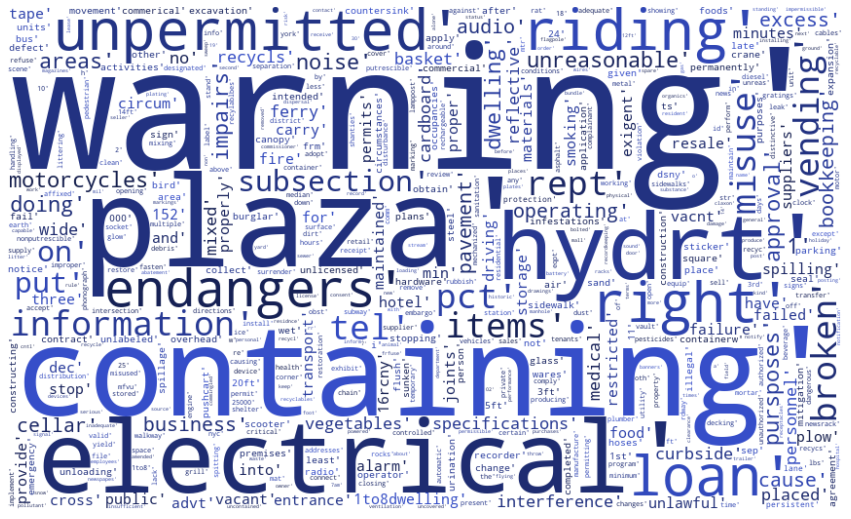

<Figure size 432x288 with 0 Axes>

In [488]:
#create a word cloud on the top 10 cited laws based on value counts
regex_token = RegexpTokenizer(r"\w+")

list_1 = df.loc[df['Charge #1: Code Section'] == "AC 16", 'Charge #1: Code Description'].tolist()
list_1 = ' '.join(list_1).lower()
list_1 = regex_token.tokenize(list_1)

list_2 = df.loc[df['Charge #1: Code Section'] == "AC 17", 'Charge #1: Code Description'].tolist()
list_2 = ' '.join(list_2).lower()
list_2 = regex_token.tokenize(list_2)

list_3 = df.loc[df['Charge #1: Code Section'] == "AC 20", 'Charge #1: Code Description'].tolist()
list_3 = ' '.join(list_3).lower()
list_3 = regex_token.tokenize(list_3)

list_4 = df.loc[df['Charge #1: Code Section'] == "AC 19", 'Charge #1: Code Description'].tolist()
list_4 = ' '.join(list_4).lower()
list_4 = regex_token.tokenize(list_4)

list_5 = df.loc[df['Charge #1: Code Section'] == "16 RCNY", 'Charge #1: Code Description'].tolist()
list_5 = ' '.join(list_5).lower()
list_5 = regex_token.tokenize(list_5)

list_6 = df.loc[df['Charge #1: Code Section'] == "AC 24", 'Charge #1: Code Description'].tolist()
list_6 = ' '.join(list_6).lower()
list_6 = regex_token.tokenize(list_6)

list_7 = df.loc[df['Charge #1: Code Section'] == "H.C. 151", 'Charge #1: Code Description'].tolist()
list_7 = ' '.join(list_7).lower()
list_7 = regex_token.tokenize(list_7)

list_8 = df.loc[df['Charge #1: Code Section'] == "34 RCNY", 'Charge #1: Code Description'].tolist()
list_8 = ' '.join(list_8).lower()
list_8 = regex_token.tokenize(list_8)

list_9 = df.loc[df['Charge #1: Code Section'] == "AC 1", 'Charge #1: Code Description'].tolist()
list_9 = ' '.join(list_9).lower()
list_9 = regex_token.tokenize(list_9)

list_10 = df.loc[df['Charge #1: Code Section'] == "H.C. 139", 'Charge #1: Code Description'].tolist()
list_10 = ' '.join(list_10).lower()
list_10 = regex_token.tokenize(list_10)


all_list = list_1 + list_2 + list_3 + list_4 + list_5 + list_6 + list_7 + list_8 + list_9 + list_10

my_list = str(list(set(all_list)))


def blue_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 230
    s = int(100.0 * 150.0 / 255.0)
    l = int(100.0 * float(random_state.randint(50, 130)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
mask = np.array(Image.open(path.join(d, "152-1522324_blue-rectangle-png-transparent-png.png")))

wc = WordCloud(max_font_size=175, 
               mask=mask, 
               background_color = 'white',
               max_words=500,
               contour_width=5, 
               contour_color='green',
               color_func = blue_color_func).generate(my_list)


plt.figure(figsize=(15,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
plt.savefig('wordcloud.png')

### Create a "Respondent Type" column

Both individuals and commerical entities can receive these tickets. For example, under the"Last Name" column, some tickets are cited as "LLC." Therefore, need to create a separate column labeling whether the respondent is a person or commercial entity.

In [639]:
df['Respondent Last Name'] = df['Respondent Last Name'].astype(str)

key_words_last_name = ["INC", "CORP","MANAGEMENT","FIRST HOME PROPERTIES","COR","3 NYC","HPENY HOUSING DEVELOPMENT FUND","RT HUDSON ELEMENTARY SCHOOL",
"DEVELOPMENT CO","HOLDING CO","BANANA KELLY HSG DEVE","AQUA PROPERTIES","THE BROOKLYN UNION GAS CO","VANDERBILT MORTGAGE AND FINANC","AMERICAN BROKERS CONDUIT","CMI BUSINESS FURNITURE",
"FRIENDS LAND DEVELOP","HARBOR VIEW PROP LTD","INGERSOLL TENANT ASSOC","THE BROOKLYN UNION GAS COMPANY ","PLAZA CONSTRUCTION","AUTO AUCTION""FIRST HOME PROP","1046 WASHINGTON AVE HDFC","DIEGO BEEKMAN MUTUAL HOUSING A",
"REV MANAGEMENT","LANDSLIDE PROPERTIES","NEIGHBORHOOD RESTORE HOUSING D","HTB ENTERPRISES LTD","ALLIANCE OF INDIVIDUA","WJR PROPERTIES INC","WJR PROPERTIES INC","KEYSPAN ENERGY DELIVERY NYC","RLTY","FIRST UNITED MORTGAGE BANKING",
"ASSET PLUSS MANAGEMENT SERVICE","KEYSPAN ENERGY DELIVERY N Y C","WELLS FARGO HOME MORT","ALLIANCE OF INDIVIDUAL","NEIGHBORHOOD RESTORE HDFC","WILMINGTON SAVINGS FUND SOCIET","YOUNG ISRAEL OF AVENUE K",
"FREMONT INVESTMENT LOAN","BELL ATLANTIC","EM ESS PETROLEUM CORP","PI CONSTRUCTION SERVICE INC","US BANK NATIONAL ASSOCIATION",
"CONKLIN MGMT CO","CON EDISON","CONSOLIDATED EDISON","EMPIRE CITY SUBWAY","DEUTSCHE BANK NATIONAL TRUST C","NATIONAL GRID",
"CONTACT HOLDINGS CORP","U S BANK NATIONAL ASSOCIATION","G G ASSOCIATES","WELLS FARGO BANK",
"FEDERAL NATIONAL MORTGAGE ASSO","LUCKY SEAFOOD","AGENT OWNER","NATIONAL GRID","AMENCAN HOME MORTGAGE","HOMESIDE LENDING","HSBC BANK USA","HSBC BANK USA NA","HIGH STATE RLTY CORP",
"NYC HOUSING AUTHORITY","PLAZA CONSTRUCTION CORP","EASY STREET PLUMBING INC","1249 WEBSTER AVE RLTY","DEVELOP", "BANK", "RESOURCES", "SERVICES", "LLC",  "SCHOOL", "HOME","NATIONAL GRID","SAM CONEY ISLAND LLC""ALL PHASE PLUMBING CORP","ERCAT REALTY CORP"]

In [640]:
def filter_respondent_test(element):

    for word in key_words_last_name:
        
        if word in element:
            return "Commercial"
      
    return "Person"

In [641]:
df["Respondent Status"] = df["Respondent Last Name"].apply(filter_respondent_test)

In [642]:
df["Respondent Status"].value_counts()

Person        170046
Commercial     43197
Name: Respondent Status, dtype: int64

In [643]:
#check to see the function works correctly
df.loc[df['Respondent Status'] == "Commercial"].head(3)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status
3,040655686J,02/02/2018,SANITATION POLICE,MENT 806,HOUSING PRESERVATION DEVELOP,QUEENS,NaN,NaN,177-12,105 AVENUE,JAMAICA,11433,NEW YORK,QUEENS,177-12,105 AVENUE,JAMAICA,11433,NEW YORK,NaN,300.0,AS06,A.C. 16-118 2 A,DIRTY SIDEWALK DIRTY AREA,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 177-12 105 AVENUE JAMAICA 11433 NEW YORK,QUEENS 177-12 105 AVENUE JAMAICA 11433 NEW YORK,0,Commercial
16,042794571M,02/19/2016,SANITATION POLICE,NaN,SHOPLAND CORP,QUEENS,10074.0,38.0,143-01,LAKEWOOD AVENUE,JAMAICA,11435,NEW YORK,QUEENS,143-01,LAKEWOOD AVENUE,JAMAICA,11435,NEW YORK,NaN,300.0,AS97,16-118 2,"DIRTY SIDEWALK,FAIL TO CLEAN 18 INTO STREET,SIDEWALK OBSTRUCTION 2ND",250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 10074.0 38.0 143-01 LAKEWOOD AVENUE JAMAICA 11435 NEW YORK,QUEENS 143-01 LAKEWOOD AVENUE JAMAICA 11435 NEW YORK,1,Commercial
26,0134517121,07/27/2005,POLICE DEPT,NaN,EN KAI INC,MANHATTAN,0.0,0.0,75,EAST BROADWAY,NEW YORK,10002,NEW YORK,MANHATTAN,75,EAST BROADWAY,NEW YORK,10002,NEW YORK,NaN,1000.0,AF01,A.C. 17-307 A,UNLICENSED MOBILE FOOD VENDOR,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 0.0 0.0 75 EAST BROADWAY NEW YORK 10002 NEW YORK,MANHATTAN 75 EAST BROADWAY NEW YORK 10002 NEW YORK,1,Commercial


In [645]:
#make sure the function applied correctly
df.loc[df['Respondent Last Name'] == "HIGH STATE RLTY CORP"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status
2550,0118659009,08/28/2001,SANITATION POLICE,NaN,HIGH STATE RLTY CORP,STATEN IS,207.0,51.0,84,STATE STREET,STATEN IS,10310,NEW YORK,STATEN IS,84,STATE STREET,STATEN IS,10310,NEW YORK,NaN,300.0,AS06,16-118 2,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STATEN IS 207.0 51.0 84 STATE STREET STATEN IS 10310 NEW YORK,STATEN IS 84 STATE STREET STATEN IS 10310 NEW YORK,0,Commercial
4424,0120429825,01/15/2000,SANITATION POLICE,NaN,HIGH STATE RLTY CORP,STATEN IS,207.0,51.0,86,STATE STREET,STATEN IS,10310,NEW YORK,STATEN IS,86,STATE STREET,STATEN IS,10310,NEW YORK,NaN,300.0,AS06,16-118 2,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STATEN IS 207.0 51.0 86 STATE STREET STATEN IS 10310 NEW YORK,STATEN IS 86 STATE STREET STATEN IS 10310 NEW YORK,0,Commercial


In [646]:
#make sure the function applied correctly
df.loc[df['Respondent Last Name'] == "NATIONAL GRID"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status
477,0178595057,11/14/2010,NYPD TRANSPORT INTELLIGENCE DI,NaN,NATIONAL GRID,QUEENS,3828.0,89.0,NaN,MYRTLE AVENUE,RIDGEWOOD,11385,NEW YORK,BROOKLYN,ONE,METROTECH CENTER,BROOKLYN,11201,NEW YORK,NaN,5000.0,AD03,19-107.,STREET CLOSING WITHOUT PERMIT,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 3828.0 89.0 MYRTLE AVENUE RIDGEWOOD 11385 NEW YORK,BROOKLYN ONE METROTECH CENTER BROOKLYN 11201 NEW YORK,1,Commercial
1062,0180278048,02/01/2012,NYPD TRANSPORT INTELLIGENCE DI,NaN,NATIONAL GRID,BROOKLYN,5085.0,8.0,NaN,ROGERS AVENUE,BROOKLYN,11226,NEW YORK,BROOKLYN,ONE,METROTECH CENTER,BROOKLYN,11201,NEW YORK,NaN,1230.0,AD4E,34RCNY2-11 E 10,FAILURE TO PIN AND OR RAMP STEEL PLATES,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN 5085.0 8.0 ROGERS AVENUE BROOKLYN 11226 NEW YORK,BROOKLYN ONE METROTECH CENTER BROOKLYN 11201 NEW YORK,1,Commercial


In [647]:
#make sure the function applied correctly
df.loc[df['Respondent Last Name'] == "CHEN"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status
877,0176473514,12/21/2010,POLICE DEPARTMENT,ZHA REN,CHEN,MANHATTAN,NaN,NaN,1270,BROADWAY,NEW YORK,10001,NEW YORK,BROOKLYN,953,59 STREET,BROOKLYN,11219,NEW YORK,MANHATTAN,NaN,AG21,20-465.1,VENDING AT TIMES PLACES RESTRICTED BY RULE OF VENDOR REV. PANEL,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 1270 BROADWAY NEW YORK 10001 NEW YORK,BROOKLYN 953 59 STREET BROOKLYN 11219 NEW YORK,0,Person
1080,0133794605,03/01/2004,NYPD TRANSPORT INTELLIGENCE DI,HUA,CHEN,MANHATTAN,809.0,80.0,435,7 AVENUE,MANHATTAN,10001,NEW YORK,BROOKLYN,447,62 STREET,BROOKLYN,11220,NEW YORK,NaN,250.0,AG23,20-465(M),"VENDING OVER VENTILATION GRILL, CELLAR DOOR, MANHOLE, ETC.",100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 809.0 80.0 435 7 AVENUE MANHATTAN 10001 NEW YORK,BROOKLYN 447 62 STREET BROOKLYN 11220 NEW YORK,0,Person


In [648]:
# Create a function to fill in UNKNOWN for all NAs in the dataframe
def fill_na(column):
    
    for x in column:
        df[x].fillna('UNKNOWN', inplace=True)
    
    return df.head(2)

In [649]:
print(list(df.columns))

columns_to_fill = ['Ticket Number', 'Violation Date', 'Issuing Agency', 'Respondent First Name', 'Respondent Last Name', 'Violation Location (Borough)', 'Violation Location (Block No.)', 'Violation Location (Lot No.)', 'Violation Location (House #)', 'Violation Location (Street Name)', 'Violation Location (City)', 'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (Borough)', 'Respondent Address (House #)', 'Respondent Address (Street Name)', 'Respondent Address (City)', 'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Decision Location (Borough)','Charge #1: Code', 'Charge #1: Code Section', 'Charge #1: Code Description', 'Charge #1: Infraction Amount', 'Charge #2: Code', 'Charge #2: Code Section', 'Charge #2: Code Description', 'Charge #2: Infraction Amount', 'Charge #3: Code', 'Charge #3: Code Section', 'Charge #3: Code Description', 'Charge #3: Infraction Amount', 'complete violation location', 'complete respondent location', 'Hearing Result']


column_names = list(columns_to_fill)
fill_na(column_names)

['Ticket Number', 'Violation Date', 'Issuing Agency', 'Respondent First Name', 'Respondent Last Name', 'Violation Location (Borough)', 'Violation Location (Block No.)', 'Violation Location (Lot No.)', 'Violation Location (House #)', 'Violation Location (Street Name)', 'Violation Location (City)', 'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (Borough)', 'Respondent Address (House #)', 'Respondent Address (Street Name)', 'Respondent Address (City)', 'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Decision Location (Borough)', 'Penalty Imposed', 'Charge #1: Code', 'Charge #1: Code Section', 'Charge #1: Code Description', 'Charge #1: Infraction Amount', 'Charge #2: Code', 'Charge #2: Code Section', 'Charge #2: Code Description', 'Charge #2: Infraction Amount', 'Charge #3: Code', 'Charge #3: Code Section', 'Charge #3: Code Description', 'Charge #3: Infraction Amount', 'complete violation location', 'complete respondent location

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status
0,046743019Y,04/11/2019,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,LONG ISLA,0.0,AS06,A.C. 16-118 2 A,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,0,Person
1,0182819771,03/24/2014,POLICE DEPARTMENT,JEFFREY,EPSTEIN,BROOKLYN,816.0,1.0,5323,5 AVENUE,BROOKLYN,11220,NEW YORK,BROOKLYN,770,NEW YORK AVENUE,BROOKLYN,11203,NEW YORK,UNKNOWN,1000.0,AF02,A.C. 17-307 B,UNPERMITTED MOBILE FOOD UNIT,1000.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BROOKLYN 816.0 1.0 5323 5 AVENUE BROOKLYN 11220 NEW YORK,BROOKLYN 770 NEW YORK AVENUE BROOKLYN 11203 NEW YORK,1,Person


### Create columns on neighborhood level income data using census data

1. main problem is USPS zip code (which is what the main df has) is different from census's zip code tabulation area number (thought a signficant portion of them match up identically). For example, one's USPS zip code could be 11333 but its zip code tabulation area could be 11332

2. Need to go through the following steps to get the census data to match up with the main dataframe 

     A. add a new column with ZIP Code Tabulation Areas (ZCTAs) so to pull census data using ZCTA
     
     B. web scrape census to get the list of ZCTA based on the dataframe 
     
     C. merge the dataframes together so each row contain neighborhood level income data 

In [ ]:
nyc_zip_codes = ["10001", "10002", "10003", "10004", "10005", "10006","10007","10009","10010","10011","10012",
                 "10013","10014","10015","10016","10017","10018","10019","10020","10021","10022","10023","10024",
                 "10025","10026","10027","10028","10029","10030","10031","10032","10033","10034","10035","10036",
                 "10037","10038","10039","10040","10041","10044","10045","10048","10055","10060","10069","10090",
                 "10095","10098","10099","10103","10104","10105","10106","10107","10110","10111","10112","10115",
                 "10118","10119","10120","10121","10122","10123","10128","10151","10152","10153","10154","10155",
                 "10158","10161","10162","10165","10166","10167","10168","10169","10170","10171","10172","10173",
                 "10174","10175","10176","10177","10178","10199","10270","10271","10278","10279","10280","10281",
                 "10282","10301","10302","10303","10304","10305","10306","10307","10308","10309","10310","10311",
                 "10312","10314","10451","10452","10453","10454","10455","10456","10457","10458","10459","10460",
                 "10461","10462","10463","10464","10465","10466","10467","10468","10469","10470","10471","10472",
                 "10473","10474","10475","11004","11101","11102","11103","11104","11105","11106","11109","11201",
                 "11203","11204","11205","11206","11207","11208","11209","11210","11211","11212","11213","11214",
                 "11215","11216","11217","11218","11219","11220","11221","11222","11223","11224","11225","11226",
                 "11228","11229","11230","11231","11232","11233","11234","11235","11236","11237","11238","11239",
                 "11241","11242","11243","11249","11252","11256","11351","11354","11355","11356","11357","11358",
                 "11359","11360","11361","11362","11363","11364","11365","11366","11367","11368","11369","11370",
                 "11371","11372","11373","11374","11375","11377","11378","11379","11385","11411","11412","11413",
                 "11414","11415","11416","11417","11418","11419","11420","11421","11422","11423","11426","11427",
                 "11428","11429","11430","11432","11433","11434","11435","11436","11691","11692","11693","11694",
                 "11697"]

In [ ]:
# this dataset contains USPS zip_code and ZCTA zip code for several states. 
# itindicates whether some a USPS zip code matches with a ZCTA code
# if certain ones doesn't match up, it indicates the equivalence of that
ZiptoZcta_Crosswalk_2021 = pd.read_excel("ZiptoZcta_Crosswalk_2021.xlsx")
ZiptoZcta_Crosswalk_2021["ZIP_CODE"] = ZiptoZcta_Crosswalk_2021["ZIP_CODE"].astype(str)
df['Respondent Address (Zip Code)'] = df['Respondent Address (Zip Code)'].astype(str)

# narrown down the df to only pull out zip codes that matches the nyc zipcode list above
ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"] = np.where(ZiptoZcta_Crosswalk_2021["ZIP_CODE"].isin(nyc_zip_codes), "NYC", "Other")

In [ ]:
print(ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"].value_counts())

ZiptoZcta_Crosswalk_2021_NYC = ZiptoZcta_Crosswalk_2021.loc[ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"] == "NYC"]
ZiptoZcta_Crosswalk_2021_NYC

In [ ]:
ZiptoZcta_Crosswalk_2021_NYC.to_csv("NYC_Only_ZiptoZcta_Crosswalk_2021.csv")

In [ ]:
#create a dic that has the usps zip code on the left and ZCTA code on the right so we can map it 
ZiptoZcta_Crosswalk_2021_NYC_dict = dict(zip(ZiptoZcta_Crosswalk_2021_NYC.ZIP_CODE, ZiptoZcta_Crosswalk_2021_NYC.ZCTA))
ZiptoZcta_Crosswalk_2021_NYC_dict

In [ ]:
#using the key above, if the respondent address column matches the key, then the new column will match it with the value
df['Respondent ZCTA'] = df['Respondent Address (Zip Code)'].map(ZiptoZcta_Crosswalk_2021_NYC_dict)

In [ ]:
df["Respondent ZCTA"].isnull().value_counts()

In [ ]:
df['Respondent ZCTA'] = df["Respondent ZCTA"].astype(str)

print("Respondent ZCTA column contains a total {} unique zip codes. I will use this list to do web scraping\
to get the relevant census files".format(len(df['Respondent ZCTA'].unique())))

Respondent_ZCTA_list = list(set(df['Respondent ZCTA']))
print(Respondent_ZCTA_list)

# Web Scraping

In [ ]:
pip install selenium

pip install chromedriver-binary

In [ ]:
import requests 
from urllib.request import urlopen 
from bs4 import BeautifulSoup 
import chromedriver_binary

from selenium import webdriver 
import chromedriver_binary

In [ ]:
driver = webdriver.Chrome("/Users/allisongao/Downloads/chromedriver 4")

ZCTA_url =[]

for x in Respondent_ZCTA_list: 
    
    ZCTA_url.append("https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US" + x + "&tid=ACSST5Y2019.S1901&hidePreview=true")

ZCTA_url

#code to auto click on the download button to get all the census data

#importing webdriver from selenium
from selenium import webdriver
# Here Chrome will be used
driver = webdriver.Chrome("/Users/allisongao/Downloads/chromedriver 4")

# selenium breaks with too much links fed all at once. so need to break it out into chunks for auto clicking the download button
firs_group = ['https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11229&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11215&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11435&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11208&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11367&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11206&tid=ACSST5Y2019.S1901&hidePreview=true',
'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US10458&tid=ACSST5Y2019.S1901&hidePreview=true']
# URL of website
for url in firs_group:
driver.get(url)
downloadBtn = driver.find_element_by_xpath("//*[text() = 'Download']")
downloadBtn.click()
time.sleep(5)
downloadBtn2 = driver.find_element_by_xpath("//button[@class='aqua-button mt-5']")
downloadBtn2.click()
time.sleep(2)
downloadBtn3=driver.find_element_by_xpath('//*[@id="table-download-now-button"]')
downloadBtn3.click()

### After web scraping is done with all the files downloaded, load census data

In [650]:
# load all the census data by zip code and concat it into a single dataframe

zcta_df = []

for x in range(1, 190):
    data = pd.read_csv(str(x) + "ACS.csv")
    
    zcta_df.append(data)
    
#merge them all horizontally 
zcta_df = pd.concat(zcta_df)   


#drop duplicated rows
zcta_df.drop_duplicates(keep='first', inplace=True)

zcta_df = zcta_df.reset_index(drop=True)

#second row is an observation for the entire country, let's drop it
zcta_df.drop(2, inplace=True)

 #change the first row for the header
new_header = zcta_df.iloc[0]
zcta_df = zcta_df[1:]
zcta_df.columns = new_header 

#make sure df is in good shape
zcta_df.head(5)

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households!!Total,"Estimate!!Households!!Total!!Less than $10,000","Margin of Error!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Margin of Error!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Margin of Error!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Margin of Error!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Margin of Error!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999","Margin of Error!!Households!!Total!!$50,000 to $74,999","Estimate!!Households!!Total!!$75,000 to $99,999","Margin of Error!!Households!!Total!!$75,000 to $99,999","Estimate!!Households!!Total!!$100,000 to $149,999","Margin of Error!!Households!!Total!!$100,000 to $149,999","Estimate!!Households!!Total!!$150,000 to $199,999","Margin of Error!!Households!!Total!!$150,000 to $199,999","Estimate!!Households!!Total!!$200,000 or more","Margin of Error!!Households!!Total!!$200,000 or more",Estimate!!Households!!Median income (dollars),Margin of Error!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),Margin of Error!!Households!!Mean income (dollars),Estimate!!Households!!PERCENT ALLOCATED!!Household income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Household income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Families!!Total,Margin of Error!!Families!!Total,"Estimate!!Families!!Total!!Less than $10,000","Margin of Error!!Families!!Total!!Less than $10,000","Estimate!!Families!!Total!!$10,000 to $14,999","Margin of Error!!Families!!Total!!$10,000 to $14,999","Estimate!!Families!!Total!!$15,000 to $24,999","Margin of Error!!Families!!Total!!$15,000 to $24,999","Estimate!!Families!!Total!!$25,000 to $34,999","Margin of Error!!Families!!Total!!$25,000 to $34,999","Estimate!!Families!!Total!!$35,000 to $49,999","Margin of Error!!Families!!Total!!$35,000 to $49,999","Estimate!!Families!!Total!!$50,000 to $74,999","Margin of Error!!Families!!Total!!$50,000 to $74,999","Estimate!!Families!!Total!!$75,000 to $99,999","Margin of Error!!Families!!Total!!$75,000 to $99,999","Estimate!!Families!!Total!!$100,000 to $149,999","Margin of Error!!Families!!Total!!$100,000 to $149,999","Estimate!!Families!!Total!!$150,000 to $199,999","Margin of Error!!Families!!Total!!$150,000 to $199,999","Estimate!!Families!!Total!!$200,000 or more","Margin of Error!!Families!!Total!!$200,000 or more",Estimate!!Families!!Median income (dollars),Margin of Error!!Families!!Median income (dollars),Estimate!!Families!!Mean income (dollars),Margin of Error!!Families!!Mean income (dollars),Estimate!!Families!!PERCENT ALLOCATED!!Household income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Household income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families!!Total,"Estimate!!Married-couple families!!Total!!Less than $10,000","Margin of Error!!Married-couple families!!Total!!Less than $10,000","Estimate!!Married-couple families!!Total!!$10,000 to $14,999","Margin of Error!!Married-couple families!!Total!!$10,000 to $14,999","Estimate!!Married-couple families!!To

In [651]:
# need to convert the Geographic Area Name column so that I can use this to merge it to the main df
zcta_df["Geographic Area Name"]= zcta_df["Geographic Area Name"].str.replace('ZCTA5', '')
zcta_df['Geographic Area Name'] = zcta_df['Geographic Area Name'].astype(str)
zcta_df['Geographic Area Name'] = zcta_df['Geographic Area Name'].str.lstrip()

In [652]:
for x in list (zcta_df.columns.tolist()):
    print(x)

id
Geographic Area Name
Estimate!!Households!!Total
Margin of Error!!Households!!Total
Estimate!!Households!!Total!!Less than $10,000
Margin of Error!!Households!!Total!!Less than $10,000
Estimate!!Households!!Total!!$10,000 to $14,999
Margin of Error!!Households!!Total!!$10,000 to $14,999
Estimate!!Households!!Total!!$15,000 to $24,999
Margin of Error!!Households!!Total!!$15,000 to $24,999
Estimate!!Households!!Total!!$25,000 to $34,999
Margin of Error!!Households!!Total!!$25,000 to $34,999
Estimate!!Households!!Total!!$35,000 to $49,999
Margin of Error!!Households!!Total!!$35,000 to $49,999
Estimate!!Households!!Total!!$50,000 to $74,999
Margin of Error!!Households!!Total!!$50,000 to $74,999
Estimate!!Households!!Total!!$75,000 to $99,999
Margin of Error!!Households!!Total!!$75,000 to $99,999
Estimate!!Households!!Total!!$100,000 to $149,999
Margin of Error!!Households!!Total!!$100,000 to $149,999
Estimate!!Households!!Total!!$150,000 to $199,999
Margin of Error!!Households!!Total!!$

In [653]:
# the census data df has a lot of information
# isolate the relevant columns for the final df

columns = ['Geographic Area Name',
           
            "Estimate!!Nonfamily households!!Median income (dollars)",
            "Estimate!!Nonfamily households!!Mean income (dollars)",
            "Estimate!!Nonfamily households!!Total!!Less than $10,000",
            "Estimate!!Nonfamily households!!Total!!$10,000 to $14,999",
            "Estimate!!Nonfamily households!!Total!!$15,000 to $24,999",
            "Estimate!!Nonfamily households!!Total!!$25,000 to $34,999",
            "Estimate!!Nonfamily households!!Total!!$35,000 to $49,999",
            "Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",
           
           
           
           "Estimate!!Households!!Median income (dollars)",
           "Estimate!!Households!!Mean income (dollars)",
           "Estimate!!Households!!Total!!Less than $10,000",
            "Estimate!!Households!!Total!!$10,000 to $14,999",
            "Estimate!!Households!!Total!!$15,000 to $24,999",
            "Estimate!!Households!!Total!!$25,000 to $34,999",
            "Estimate!!Households!!Total!!$35,000 to $49,999",
            "Estimate!!Households!!Total!!$50,000 to $74,999"]
           

In [654]:
zcta_df = zcta_df[columns]
zcta_df.head(8)

,Geographic Area Name,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
1,10005,180389,180629,6.3,0.5,2.9,0.0,2.4,7.9,189702,225453,4.5,0.3,2.6,0.3,1.7,6.2
3,10002,31767,65351,20.9,13.5,11.2,6.2,7.8,9.4,36982,69323,14.7,11.8,13.3,8.6,10.9,11.0
4,10003,95812,146060,7.6,3.0,6.2,5.5,6.5,14.4,118161,196931,5.8,2.5,4.8,4.9,6.1,12.5
5,11215,91672,108235,7.4,4.2,5.3,5.5,5.8,12.7,132091,183544,4.0,2.1,3.2,3.4,4.4,9.1
6,10031,45735,68336,14.5,8.8,10.0,8.0,12.6,12.8,53660,78767,9.8,7.1,9.8,9.4,11.8,14.8
7,11208,24462,37087,23.3,10.5,17.0,11.7,12.3,10.6,42403,60092,15.0,5.9,11.5,9.7,13.5,15.1
8,10023,100531,147850,8.5,3.5,6.0,5.9,4.9,11.0,132605,228373,5.7,2.6,5.4,4.9,3.7,8.0
9,11217,94148,120780,10.1,2.9,7.0,4.8,6.2,9.4,119375,172251,6.7,1.9,5.4,5.0,6.4,8.7


In [655]:
zcta_df = zcta_df.rename(columns={"Geographic Area Name": 'Respondent Address (Zip Code)'})

In [656]:
column_need_convert = ["Estimate!!Nonfamily households!!Median income (dollars)",
            "Estimate!!Nonfamily households!!Mean income (dollars)",
            "Estimate!!Nonfamily households!!Total!!Less than $10,000",
            "Estimate!!Nonfamily households!!Total!!$10,000 to $14,999",
            "Estimate!!Nonfamily households!!Total!!$15,000 to $24,999",
            "Estimate!!Nonfamily households!!Total!!$25,000 to $34,999",
            "Estimate!!Nonfamily households!!Total!!$35,000 to $49,999",
            "Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",

           "Estimate!!Households!!Median income (dollars)",
           "Estimate!!Households!!Mean income (dollars)",
           "Estimate!!Households!!Total!!Less than $10,000",
            "Estimate!!Households!!Total!!$10,000 to $14,999",
            "Estimate!!Households!!Total!!$15,000 to $24,999",
            "Estimate!!Households!!Total!!$25,000 to $34,999",
            "Estimate!!Households!!Total!!$35,000 to $49,999",
            "Estimate!!Households!!Total!!$50,000 to $74,999"]

In [657]:
for x in column_need_convert:
    
    zcta_df[x].replace('-', np.nan, inplace=True)
    zcta_df[x] = zcta_df[x].astype("float64")
    zcta_df[x].fillna(zcta_df[x].mean(), inplace=True)

In [658]:
zcta_df.describe()

,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.070520,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.573410,9.932370,14.142197
std,28147.577782,36969.575696,6.580736,5.462772,3.919859,3.261574,3.539196,4.027074,33669.973060,51869.698262,4.531117,3.268641,3.532255,2.618382,3.096504,3.318577
min,12857.000000,24496.000000,1.500000,0.000000,0.600000,0.000000,1.300000,2.400000,21447.000000,39790.000000,1.200000,0.000000,0.500000,0.300000,1.200000,3.700000
25%,34757.500000,50477.000000,8.800000,5.800000,9.000000,6.300000,8.100000,11.550000,54242.500000,74768.250000,4.500000,2.900000,6.150000,6.000000,8.400000,13.000000
50%,46186.500000,64669.000000,12.450000,8.850000,11.201734,8.663584,10.505202,14.070520,73238.500000,94776.500000,6.700000,4.700000,8.372254,7.573410,9.932370,14.500000
75%,58608.250000,76204.250000,15.600000,10.825000,13.550000,10.925000,12.525000,16.300000,88172.500000,113336.750000,9.275000,6.700000,10.100000,9.400000,12.125000,16.025000
max,180389.000000,268474.000000,35.900000,31.100000,23.800000,22.200000,22.000000,26.600000,224063.000000,358261.000000,23.600000,16.900000,18.800000,14.900000,17.000000,22.200000


### Merge main df with the census df

In [659]:
merged_train_df = pd.merge(df, zcta_df, how="outer", on=["Respondent Address (Zip Code)"])

In [663]:
# the merge created two rows contains null values. 
merged_train_df.tail()

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
213240,0169901968,03/30/2012,POLICE DEPARTMENT,KIM D,GRAY,BRONX,3384.0,13.0,314,EAST 236 STREET,BRONX,10470,NEW YORK,NOT NYC,222,FAYETTE ST,PALMYRA,14522,NEW YORK,UNKNOWN,10500.0,AN12,A.C. 24-222,CONSTRUCTION ACTIVITIES AT IMPERMISSIBLE TIMES DAYS-3RD,4200.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BRONX 3384.0 13.0 314 EAST 236 STREET BRONX 10470 NEW YORK,NOT NYC 222 FAYETTE ST PALMYRA 14522 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213241,046643137R,06/01/2019,SANITATION POLICE,IVOR,SAMUELS,BRONX,5263.0,40.0,3565,BIVONA STREET,BRONX,10475,NEW YORK,NOT NYC,549,W SENECA TPKE,SYRACUSE,13207,NEW YORK,BRONX,0.0,ASJ5,16-461 A 1,REMOVAL TRANSPORT OF RESIDENTIAL RECYCLABLE MATERIAL OPERATOR -1ST,500.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BRONX 5263.0 40.0 3565 BIVONA STREET BRONX 10475 NEW YORK,NOT NYC 549 W SENECA TPKE SYRACUSE 13207 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213242,0108594301,04/14/1999,SANITATION POLICE,RVICE,INTERBORO CAR SE,BROOKLYN,UNKNOWN,UNKNOWN,1773,BUSHWICK AVENUE,BROOKLYN,11207,NEW YORK,NOT NYC,UNKNOWN,1773 BUSHWICK AVE,BROOKLYN,11707,NEW YORK,BROOKLYN,50.0,AS07,16-118 2,SIDEWALK OBSTRUCTION,0.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BROOKLYN 1773 BUSHWICK AVENUE BROOKLYN 11207 NEW YORK,NOT NYC 1773 BUSHWICK AVE BROOKLYN 11707 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.07052,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.57341,9.93237,14.142197
213244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.07052,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.57341,9.93237,14.142197


In [664]:
merged_train_df = merged_train_df.drop(index = [213243,213244])

In [665]:
#check to make sure it is dropped
merged_train_df.tail()

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,Respondent Status,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
213238,0155504948,06/13/2007,POLICE DEPARTMENT,LUINI DPOURE,OVE DRADGO,MANHATTAN,11.0,1.0,2,BROADWAY,NEW YORK,10004,NEW YORK,NOT NYC,6216,NILE PL,GREENSBORO,27409,NEW YORK,MANHATTAN,NaN,AG15,20-465 E,VENDING IN BUS STOP TAXI STAND 10 FT. OF DRIVE SUBWAY CORNER,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 11.0 1.0 2 BROADWAY NEW YORK 10004 NEW YORK,NOT NYC 6216 NILE PL GREENSBORO 27409 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213239,0148217410,06/27/2005,SANITATION POLICE,UNKNOWN,MAZALOT LLC,BRONX,UNKNOWN,UNKNOWN,857,EAST 169 STREET,BRONX,10459,NEW YORK,BRONX,857,169TH ST,BRONX,107,NEW YORK,UNKNOWN,300.0,AS06,16-118 2,DIRTY SIDEWALK,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BRONX 857 EAST 169 STREET BRONX 10459 NEW YORK,BRONX 857 169TH ST BRONX 00107 NEW YORK,1.0,Commercial,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213240,0169901968,03/30/2012,POLICE DEPARTMENT,KIM D,GRAY,BRONX,3384.0,13.0,314,EAST 236 STREET,BRONX,10470,NEW YORK,NOT NYC,222,FAYETTE ST,PALMYRA,14522,NEW YORK,UNKNOWN,10500.0,AN12,A.C. 24-222,CONSTRUCTION ACTIVITIES AT IMPERMISSIBLE TIMES DAYS-3RD,4200.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BRONX 3384.0 13.0 314 EAST 236 STREET BRONX 10470 NEW YORK,NOT NYC 222 FAYETTE ST PALMYRA 14522 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213241,046643137R,06/01/2019,SANITATION POLICE,IVOR,SAMUELS,BRONX,5263.0,40.0,3565,BIVONA STREET,BRONX,10475,NEW YORK,NOT NYC,549,W SENECA TPKE,SYRACUSE,13207,NEW YORK,BRONX,0.0,ASJ5,16-461 A 1,REMOVAL TRANSPORT OF RESIDENTIAL RECYCLABLE MATERIAL OPERATOR -1ST,500.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BRONX 5263.0 40.0 3565 BIVONA STREET BRONX 10475 NEW YORK,NOT NYC 549 W SENECA TPKE SYRACUSE 13207 NEW YORK,0.0,Person,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213242,0108594301,04/14/1999,SANITATION POLICE,RVICE,INTERBORO CAR SE,BROOKLYN,UNKNOWN,UNKNOWN,1773,BUSHWICK AVENUE,BROOKLYN,11207,NEW YORK,NOT NYC,UNKNOWN,1773 BUSHWICK AVE,BROOKLYN,11707,NEW YORK,BROOKLYN,50.0,AS07,16-118 2,SIDEWALK OBSTR

In [666]:
#moved the target column to the first for easier visual
first_column = merged_train_df.pop('Hearing Result')
merged_train_df.insert(0, 'Hearing Result', first_column)
merged_train_df.head(2)

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Respondent Status,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,046743019Y,04/11/2019,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,LONG ISLA,0.0,AS06,A.C. 16-118 2 A,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,Person,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,0114221059,12/23/2001,POLICE DEPARTMENT,MOHAMMED,SARKAR,MANHATTAN,1264.0,5.0,1230,AVENUE OF THE AMERICAS,MANHATTAN,10020,NEW YORK,QUEENS,34-16,93 STREET,QUEENS,11372,NEW YORK,UNKNOWN,1000.0,AF18,17-315(E),"IN BUS STOP, OR 10 FT. OF DRIVE, SUBWAY, CROSSWALK, ETC.",100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1264.0 5.0 1230 AVENUE OF THE AMERICAS MANHATTAN 10020 NEW YORK,QUEENS 34-16 93 STREET QUEENS 11372 NEW YORK,Person,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [667]:
#there are columns where the ZCTA did not match up with a zip code, so need to fill those in with a value 

list_to_convert = ['Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
       'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999',
       'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999',
       'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999',
       'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Households!!Mean income (dollars)',
       'Estimate!!Households!!Total!!Less than $10,000',
       'Estimate!!Households!!Total!!$10,000 to $14,999',
       'Estimate!!Households!!Total!!$15,000 to $24,999',
       'Estimate!!Households!!Total!!$25,000 to $34,999',
       'Estimate!!Households!!Total!!$35,000 to $49,999',
       'Estimate!!Households!!Total!!$50,000 to $74,999']

In [668]:
def fill_na(column):
    for x in column:
        merged_train_df[x].fillna(0, inplace=True)
    
    return merged_train_df.head(2)

In [669]:
fill_na(list_to_convert)

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Respondent Status,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,046743019Y,04/11/2019,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,LONG ISLA,0.0,AS06,A.C. 16-118 2 A,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,Person,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,0114221059,12/23/2001,POLICE DEPARTMENT,MOHAMMED,SARKAR,MANHATTAN,1264.0,5.0,1230,AVENUE OF THE AMERICAS,MANHATTAN,10020,NEW YORK,QUEENS,34-16,93 STREET,QUEENS,11372,NEW YORK,UNKNOWN,1000.0,AF18,17-315(E),"IN BUS STOP, OR 10 FT. OF DRIVE, SUBWAY, CROSSWALK, ETC.",100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1264.0 5.0 1230 AVENUE OF THE AMERICAS MANHATTAN 10020 NEW YORK,QUEENS 34-16 93 STREET QUEENS 11372 NEW YORK,Person,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [670]:
merged_train_df.describe()

,Hearing Result,Penalty Imposed,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
count,213243.000000,190627.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000
mean,0.395985,369.536162,39336.147892,58100.072190,16.728870,11.569240,11.999639,8.807942,10.341525,13.025193,56914.406210,81171.178678,9.930182,6.726017,10.010926,8.564571,11.017483,14.737414
std,0.489062,567.460003,23004.501199,31277.618882,7.897487,6.034791,3.629475,3.114909,3.175820,4.044706,25559.854839,40595.165798,5.330458,3.424786,3.570881,2.527763,3.029994,3.644875
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,100.000000,23848.000000,38123.000000,10.200000,7.400000,10.200000,6.600000,8.500000,10.700000,39382.000000,60092.000000,6.000000,4.200000,7.900000,7.300000,9.800000,13.400000
50%,0.000000,300.000000,34893.000000,51360.000000,15.400000,10.400000,12.400000,9.000000,10.200000,13.000000,54457.000000,75364.000000,8.300000,6.200000,9.700000,9.000000,11.200000,15.100000
75%,1.000000,300.000000,48343.000000,68336.000000,23.300000,16.200000,14.700000,11.000000,12.400000,15.200000,68530.000000,90753.000000,14.400000,9.000000,12.400000,10.100000,13.500000,17.000000
max,1.000000,25000.000000,180389.000000,268474.000000,35.900000,31.100000,23.800000,22.200000,22.000000,26.600000,224063.000000,358261.000000,23.600000,16.900000,18.800000,14.900000,17.000000,22.200000


In [671]:
merged_train_df.isnull().sum()

Hearing Result                                                   0
Ticket Number                                                    0
Violation Date                                                   0
Issuing Agency                                                   0
Respondent First Name                                            0
Respondent Last Name                                             0
Violation Location (Borough)                                     0
Violation Location (Block No.)                                   0
Violation Location (Lot No.)                                     0
Violation Location (House #)                                     0
Violation Location (Street Name)                                 0
Violation Location (City)                                        0
Violation Location (Zip Code)                                    0
Violation Location (State Name)                                  0
Respondent Address (Borough)                                  

### Only keeping the necessary columns for a cleaner df for modeling

In [267]:
merged_train_df.drop(columns = ["WEEKDAY","month",'Ticket Number', 'Violation Date',
       'Respondent First Name', 'Respondent Last Name', 'Violation Location (Block No.)',
       'Violation Location (Lot No.)', 'Violation Location (House #)',
       'Violation Location (Street Name)', 'Violation Location (City)',
       'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (House #)',
       'Respondent Address (Street Name)', 'Respondent Address (City)',
       'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Penalty Imposed',
       'Charge #1: Code', 
       'Charge #1: Code Description', 'Charge #1: Infraction Amount',
       'Charge #2: Code', 'Charge #2: Code Section',
       'Charge #2: Code Description', 'Charge #2: Infraction Amount',
       'Charge #3: Code', 'Charge #3: Code Section',
       'Charge #3: Code Description', 'Charge #3: Infraction Amount',
       'complete violation location', 'complete respondent location'], axis=1, inplace=True)
merged_train_df.head(3)

,Hearing Result,Issuing Agency,Violation Location (Borough),Respondent Address (Borough),Decision Location (Borough),Charge #1: Code Section,weekend_indi,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,SANITATION POLICE,QUEENS,QUEENS,In Person QUEENS,AC 16,0.0,Spring,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,NYPD,MANHATTAN,QUEENS,UNKNOWN,AC 17,1.0,Winter,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
2,0.0,NYPD,MANHATTAN,QUEENS,In Person MANHATTAN,AC 17,0.0,Fall,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


### Save train df for modeling

In [268]:
merged_train_df.to_csv('merged_train_df.csv')

# Part 3
Modeling on the training set

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split,cross_validate , GridSearchCV, cross_val_predict


from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, ConfusionMatrixDisplay, classification_report

In [18]:
# load the dataset
df = pd.read_csv("merged_train_df.csv", low_memory = False)
df.drop("Unnamed: 0", inplace=True, axis=1)
df["Respondent ZCTA"]= df["Respondent ZCTA"].astype(str)

In [19]:
df["Estimate!!Nonfamily households!!Median income (dollars)"].isnull().sum()

0

In [20]:
list_to_convert = ['Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
       'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999',
       'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999',
       'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999',
       'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Households!!Mean income (dollars)',
       'Estimate!!Households!!Total!!Less than $10,000',
       'Estimate!!Households!!Total!!$10,000 to $14,999',
       'Estimate!!Households!!Total!!$15,000 to $24,999',
       'Estimate!!Households!!Total!!$25,000 to $34,999',
       'Estimate!!Households!!Total!!$35,000 to $49,999',
       'Estimate!!Households!!Total!!$50,000 to $74,999']

In [21]:
def fill_na(column):
    for x in column:
        df[x].fillna(0, inplace=True)
    
    return df.head(2)

In [22]:
fill_na(list_to_convert)

,Hearing Result,Issuing Agency,Violation Location (Borough),Respondent Address (Borough),Decision Location (Borough),Charge #1: Code Section,weekend_indi,Season,Respondent Status,Respondent ZCTA,...,"Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,SANITATION POLICE,QUEENS,QUEENS,In Person QUEENS,AC 16,0.0,Spring,Person,11372.0,...,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,NYPD,MANHATTAN,QUEENS,UNKNOWN,AC 17,1.0,Winter,Person,11372.0,...,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [23]:
x_train = df.drop("Hearing Result", axis=1)
y_train = df["Hearing Result"]

In [24]:
#double check to make sure these are correct by looking at the distribution
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts(normalize=True))

(213243, 25)
(213243,)
0.0    0.604015
1.0    0.395985
Name: Hearing Result, dtype: float64


In [25]:
#dentify the categorical categories for one hot encoding
categorical_columns = ['Issuing Agency',
               "Respondent Address (Borough)",
                "Violation Location (Borough)", 
                 "Decision Location (Borough)",
                 "Charge #1: Code Section",
                "Season","Respondent Status","Respondent ZCTA"]


ohe_col_trans = ColumnTransformer(transformers=
                                  [('ohe', OneHotEncoder(drop='first',sparse=False), 
                                    categorical_columns)],
                                  remainder='passthrough')

### Set up functions here before modeling

In [26]:
def print_cv_scores(pipe, X, y):
    '''
    Runs cross_validate and printing the scoring results for both training and cross_val.
    '''
    scoring = ['accuracy','precision']
    
    results = cross_validate(pipe, 
                             X, 
                             y, 
                             return_train_score=True, 
                             scoring=scoring)
    
    print(results['train_accuracy'])
    print('Training Accuracy', results['train_accuracy'].mean())
    print('##############')
    print(results['test_accuracy'])
    print('Cross_Val Accuracy', results['test_accuracy'].mean())
    print('##############')
    print('Training Precision:', results['train_precision'].mean())
    print('Cross_Val Precision:', results['test_precision'].mean())

In [27]:
display_labels = ['No Fine Collected', 
                  'Fine Collected']

def print_cm_with_labels(y_true, 
                         y_pred, 
                         display_labels):
    
    
    '''
    Takes the true values and predicted values of a classifier and 
    plots a confusion matrix (normalized by predictions) using 
    a list of given display labels.
    '''
    cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  )

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(display_labels,rotation=45);

### First Simple Model

In [37]:
dummy_model = DummyClassifier(strategy="stratified")
dummy_model.fit(x_train, y_train)
dummy_model.predict(x_train)
cv_results = cross_validate(dummy_model, x_train, y_train, return_train_score=True)

y_hat = dummy_model.predict(x_train)



print('Mean Test Score: {}'.format(cv_results['test_score'].mean()))
print('Mean Train Score: {}'.format(cv_results['train_score'].mean()))


acc = accuracy_score(y_train,y_hat)
macro_precision_score=precision_score(y_train, y_hat, average='macro')
micro_precision_score=precision_score(y_train, y_hat, average='micro')
macro_recall_score=recall_score(y_train, y_hat, average='macro')
micro_recall_score=recall_score(y_train, y_hat, average='micro')

print('Accuracy Score: {}'.format(acc))
print('Macro Precision Score: {}'.format(macro_precision_score))
print('Micro Precision Score: {}'.format(micro_precision_score))
print('Macro Recall Score: {}'.format(macro_recall_score))
print('Micro Recall Score: {}'.format(micro_recall_score))

Mean Test Score: 0.5222492420770084
Mean Train Score: 0.5218143151159935
Accuracy Score: 0.5215036366961635
Macro Precision Score: 0.49996530944810014
Micro Precision Score: 0.5215036366961635
Macro Recall Score: 0.49996529476727225
Micro Recall Score: 0.5215036366961635


In [38]:
print_cv_scores(dummy_model, x_train, y_train)

[0.51978968 0.52103239 0.52225752 0.52073038 0.5221255 ]
Training Accuracy 0.5211870958464111
##############
[0.52118455 0.5253816  0.52031701 0.52572219 0.52511255]
Cross_Val Accuracy 0.5235435805516667
##############
Training Precision: 0.3952575936647166
Cross_Val Precision: 0.3988318764091338


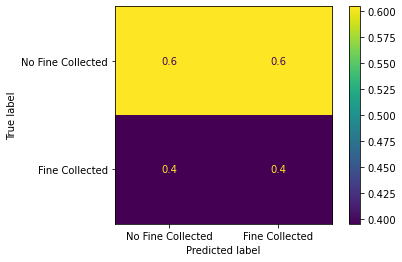

In [39]:
plot_confusion_matrix(dummy_model, x_train, y_train, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

#### So these are the baseline numbers to work off on to see how the following models can improve these two scores

### Logistic Regression

In [40]:
# Isolate the categorical and numeric columns
categorical_cols = x_train.select_dtypes('object')
numerical_cols = x_train.select_dtypes(exclude=['object'])

# Create a pipeline to encode the categorical (OneHotEncoder) and scale the numeric columns (StandardScaler)
categorical_pipeline = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])
numerical_pipeline = Pipeline(steps=[('ss', StandardScaler())])

# Create transformer with both categorical and numeric pipelines
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, numerical_cols.columns),
    ('categorical', categorical_pipeline, categorical_cols.columns)
])

# Create a pipeline with the transformer and the model
lr_pipline = Pipeline(steps=[('trans', trans),
                              ('model', LogisticRegression(random_state=42))])

In [41]:
# Create a grid search to get the best hyperparameters for the logistic regression model
lr_grid = {'model__C' : [0.5, 1],
       'model__max_iter' : [1000000, 2000000],
       'model__class_weight': [None, 'balanced']}

lr_gs = GridSearchCV(lr_pipline, lr_grid, cv=3, return_train_score=True)

In [42]:
#train it on the training set
lr_gs.fit(x_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('trans',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['weekend_indi',
       'Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily hous...
                                                                         Index(['Issuing Agency', 'Violation Location (Borough)',
       'Respondent Address (Borough)', 'Decision Location (Borough)',
       'Charge #1: Code Section', 'Season', 'Respondent Status',
       'Respondent ZCTA'],
      dtype='objec

{'model__C': 0.5, 'model__class_weight': None, 'model__max_iter': 1000000}
Mean Train Score: 0.6792596943393219'
Mean Test Score: 0.6253253330707221

Precision Score: 0.547617058020668
Accuracy Score:0.636081840904508


[0.69090941 0.69435619 0.69093872 0.68610452 0.68556523]
Training Accuracy 0.689574813100409
##############
[0.6501442  0.61180801 0.63520833 0.610861   0.67238792]
Cross_Val Accuracy 0.6360818928880931
##############
Training Precision: 0.6313001181609766
Cross_Val Precision: 0.5677102888345541


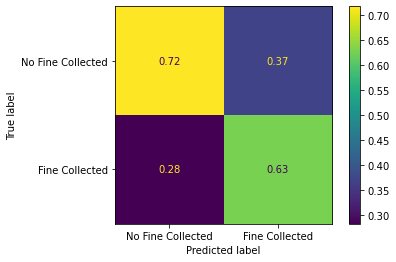

In [43]:
#get the best parameters
print(lr_gs.best_params_)

#obtain the accuracy scores
print(f'''Mean Train Score: {lr_gs.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {lr_gs.cv_results_['mean_test_score'].mean()}''')

# get the y hat 
lr_y_pred = cross_val_predict(lr_gs.best_estimator_, x_train, y_train)

print(f'''
Precision Score: {precision_score(y_train,lr_y_pred)}
Accuracy Score:{accuracy_score(y_train,lr_y_pred)}

''')

print_cv_scores(lr_gs.best_estimator_, x_train, y_train)

#display confusion matrix
plot_confusion_matrix(lr_gs.best_estimator_, x_train, y_train, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

Logistic Regression has an accuracy score of 64% and a precision score of 57%. Based on the confusion matrix, it is better at predicting "No Fine Collected" class relative to the "Fine Collected" class. 

In [44]:
# get important features highlighted by logstic regression. 
#If logistic regression is the best model, will circle back to look into the important features.
importance = lr_gs.best_estimator_[1].coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
#     plt.bar([x for x in range(len(importance))], importance)
#     plt.show()

Feature: 0, Score: 0.05942
Feature: 1, Score: -0.33488
Feature: 2, Score: -0.48881
Feature: 3, Score: -0.20766
Feature: 4, Score: 0.18023
Feature: 5, Score: -0.26760
Feature: 6, Score: -0.00742
Feature: 7, Score: -0.10331
Feature: 8, Score: 0.04618
Feature: 9, Score: 0.63381
Feature: 10, Score: 0.10975
Feature: 11, Score: 0.21786
Feature: 12, Score: -0.41677
Feature: 13, Score: 0.23937
Feature: 14, Score: 0.11132
Feature: 15, Score: 0.13019
Feature: 16, Score: -0.03619
Feature: 17, Score: -0.75187
Feature: 18, Score: -0.61254
Feature: 19, Score: 0.67696
Feature: 20, Score: -0.46773
Feature: 21, Score: 0.96537
Feature: 22, Score: -0.17292
Feature: 23, Score: 0.21326
Feature: 24, Score: 0.24986
Feature: 25, Score: -0.92267
Feature: 26, Score: 0.24754
Feature: 27, Score: -0.86702
Feature: 28, Score: 1.06215
Feature: 29, Score: -0.16039
Feature: 30, Score: -0.17918
Feature: 31, Score: -0.09403
Feature: 32, Score: 0.30947
Feature: 33, Score: -0.37323
Feature: 34, Score: -0.24206
Feature: 35

# Decision Tree

Mean Train Score: 0.6340788443231431'
Mean Test Score: 0.6128595076977907

Precision Score: 0.539066974595843
Accuracy Score:0.6238469727025037


[0.66298932 0.62379685 0.65076732 0.63869398 0.63775609]
Training Accuracy 0.6428007122758459
##############
[0.63248845 0.60233534 0.61019016 0.64427406 0.62994748]
Cross_Val Accuracy 0.6238470971020864
##############
Training Precision: 0.5775597372755796
Cross_Val Precision: 0.5420538253995086


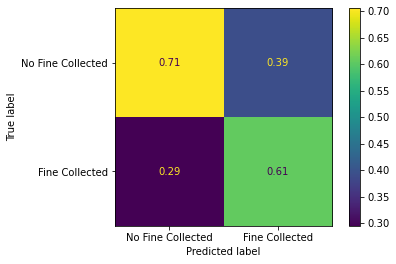

In [45]:
# create a pipeline
dt_pipline = Pipeline(steps=[('trans', trans),
                              ('model', DecisionTreeClassifier(random_state=42))])

dt_grid = {'model__max_depth' : [5, 7],
       'model__min_samples_leaf' : [3,5],
       'model__max_features': ['sqrt', 'auto']}

#create a grid search
dt_gs = GridSearchCV(dt_pipline, dt_grid, cv=3, return_train_score=True)

#train it on the training set
dt_gs.fit(x_train, y_train)

#get the best parameters out of the grid search
dt_gs.best_params_

#Print results
print(f'''Mean Train Score: {dt_gs.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {dt_gs.cv_results_['mean_test_score'].mean()}''')

dt_y_pred = cross_val_predict(dt_gs.best_estimator_, x_train, y_train)

print(f'''
Precision Score: {precision_score(y_train,dt_y_pred)}
Accuracy Score:{accuracy_score(y_train,dt_y_pred)}

''')

print_cv_scores(dt_gs.best_estimator_, x_train, y_train)

plot_confusion_matrix(dt_gs.best_estimator_, x_train, y_train, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

Decision Tree has an accuracy score of 64% and a precision score of 54%. So slightly lower than logistic regression in terms of the precision score. Based on the confusion matrix, it is also better at predicting "No Fine Collected" class relative to the "Fine Collected" class.

# Random Forest

In [46]:
# random forest does not need the values scaled.
ohe_trans = ColumnTransformer(transformers=[('categorical', categorical_pipeline, categorical_cols.columns)],
                              remainder='passthrough')

rf_pipline = Pipeline(steps=[('ohe_trans', ohe_trans),
                              ('model', RandomForestClassifier(random_state=42))])

In [47]:
# Create grid search to get the best hyperparameters for our random forest model
rf_grid= {'model__criterion':['gini', 'entropy'],
         'model__max_depth':[None,3,5],
         'model__min_samples_split':[2,10],
         'model__min_samples_leaf':[3,5,7],
         'model__max_features' : [5,10]}

rf_gs = GridSearchCV(rf_pipline, rf_grid, cv=3, return_train_score=True)

# Fit the training data in the grid search
rf_gs.fit(x_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Issuing Agency', 'Violation Location (Borough)',
       'Respondent Address (Borough)', 'Decision Location (Borough)',
       'Charge #1: Code Section', 'Season', 'Respondent Status',
       'Respondent ZCTA'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
         

{'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10}
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10}
Mean Train Score: 0.6486830426112724'
Mean Test Score: 0.6228262931126566

Precision Score: 0.5916642091811658
Accuracy Score:0.6564904826887635




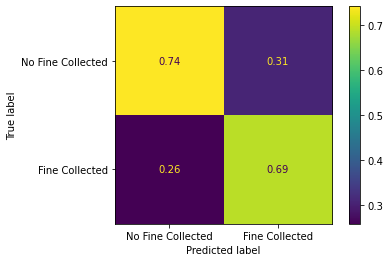

In [48]:
print(rf_gs.best_params_)

print(f'''Best Parameters: {rf_gs.best_params_}''')


print(f'''Mean Train Score: {rf_gs.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {rf_gs.cv_results_['mean_test_score'].mean()}''')

rf_y_pred = cross_val_predict(rf_gs.best_estimator_, x_train, y_train)

print(f'''
Precision Score: {precision_score(y_train,rf_y_pred)}
Accuracy Score:{accuracy_score(y_train,rf_y_pred)}

''')

plot_confusion_matrix(rf_gs.best_estimator_, x_train, y_train, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

In [49]:
print_cv_scores(rf_gs.best_estimator_, x_train, y_train)

[0.72986154 0.73466828 0.73047704 0.72413611 0.72498608]
Training Accuracy 0.7288258096742088
##############
[0.66688551 0.64775259 0.65030833 0.64368786 0.67381823]
Cross_Val Accuracy 0.6564905039091018
##############
Training Precision: 0.6935265769365225
Cross_Val Precision: 0.6027214357669047


In [50]:
#get feature importance
ohe_col_names = list(rf_gs.best_estimator_[0].transformers_[0][1][0].get_feature_names(categorical_cols.columns))

# Combine onehotencoded columsn with numeric columns
col_names = ohe_col_names + list(numerical_cols.columns)

In [51]:
pd.set_option('display.max_rows', 1000000000)
feature_importance_df = pd.DataFrame({'Features' : col_names, 'Importances' : rf_gs.best_estimator_[1].feature_importances_})
feature_importance_df.sort_values(by = "Importances", ascending = False)

,Features,Importances
38,Charge #1: Code Section_AC 10,7.886716e-02
0,Issuing Agency_NYPD,7.371998e-02
42,Charge #1: Code Section_AC 20,4.993654e-02
3,Issuing Agency_SANITATION POLICE,3.684909e-02
25,Decision Location (Borough)_UNKNOWN,3.602328e-02
40,Charge #1: Code Section_AC 17,3.252564e-02
71,Respondent Status_Person,2.899540e-02
39,Charge #1: Code Section_AC 16,2.782188e-02
4,Issuing Agency_UNKNOWN,2.442530e-02
70,Respondent Status_Commercial,2.405007e-02


Decision Tree has an accuracy score of 66% and a precision score of 60%. This is the best performing model so far; better than logistic regression and decision tree in terms of the precision score. Based on the confusion matrix, it is also better at predicting "No Fine Collected" class relative to the "Fine Collected" class.

# XGBoost

In [52]:
xgb_pipeline = Pipeline(steps=[('ohe_trans', ohe_trans),
                               ('model', XGBClassifier(random_state=42))])

In [53]:
xgb_grid = {'model__n_estimators':[50,90],
            'model__alpha':[10,16],
            'model__max_depth':[3,5]}

xgb_gs = GridSearchCV(estimator=xgb_pipeline, param_grid=xgb_grid, cv=3, return_train_score=True)

# Fit the training data to the grid search
xgb_gs.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:49] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:33:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:02] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:09] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:28] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:34:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:35:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:36:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:29] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:37:44] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ohe_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Issuing Agency', 'Violation Location (Borough)',
       'Respondent Address (Borough)', 'Decision Location (Borough)',
       'Charge #1: Code Section', 'Season', 'Respondent Statu...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                          

{'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10}
Best Parameters: {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10}
Mean Train Score: 0.6486830426112724'
Mean Test Score: 0.6228262931126566

Precision Score: 0.5916642091811658
Accuracy Score:0.6564904826887635




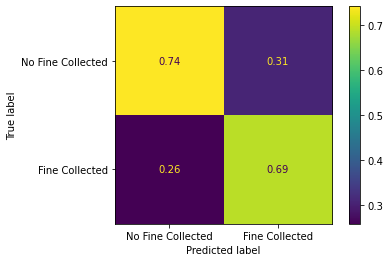

In [54]:
print(rf_gs.best_params_)

print(f'''Best Parameters: {rf_gs.best_params_}''')


print(f'''Mean Train Score: {rf_gs.cv_results_['mean_train_score'].mean()}'
Mean Test Score: {rf_gs.cv_results_['mean_test_score'].mean()}''')

rf_y_pred = cross_val_predict(rf_gs.best_estimator_, x_train, y_train)

print(f'''
Precision Score: {precision_score(y_train,rf_y_pred)}
Accuracy Score:{accuracy_score(y_train,rf_y_pred)}

''')

plot_confusion_matrix(rf_gs.best_estimator_, x_train, y_train, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

In [55]:
print_cv_scores(rf_gs.best_estimator_, x_train, y_train)

[0.72986154 0.73466828 0.73047704 0.72413611 0.72498608]
Training Accuracy 0.7288258096742088
##############
[0.66688551 0.64775259 0.65030833 0.64368786 0.67381823]
Cross_Val Accuracy 0.6564905039091018
##############
Training Precision: 0.6935265769365225
Cross_Val Precision: 0.6027214357669047


XGBoost has an accuracy score of 66% and a precision score of 60%. This is the same as Random Forest, which was consider the best performing model before XGBoost(better than logistic regression and decision tree in terms of the precision score). Based on the confusion matrix, it is also better at predicting "No Fine Collected" class relative to the "Fine Collected" class.

# Part 4
Since Random Forest and XGBoost both produced the same scores. Will run both models on the unseen data to see which one does better.

In [56]:
#this holdout set has been cleaned like the training set on a separate notebook. So we just need to import it
df_test = pd.read_csv("merged_test_df.csv", low_memory = False)
df_test.drop("Unnamed: 0", inplace=True, axis=1)
df_test["Respondent ZCTA"]= df_test["Respondent ZCTA"].astype(str)

In [57]:
list_to_convert = ['Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
       'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999',
       'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999',
       'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999',
       'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Households!!Mean income (dollars)',
       'Estimate!!Households!!Total!!Less than $10,000',
       'Estimate!!Households!!Total!!$10,000 to $14,999',
       'Estimate!!Households!!Total!!$15,000 to $24,999',
       'Estimate!!Households!!Total!!$25,000 to $34,999',
       'Estimate!!Households!!Total!!$35,000 to $49,999',
       'Estimate!!Households!!Total!!$50,000 to $74,999']

In [58]:
def fill_na(column):
    for x in column:
        df_test[x].fillna(0, inplace=True)
    
    return df_test.head(2)

In [59]:
fill_na(list_to_convert)

,Hearing Result,Issuing Agency,Violation Location (Borough),Respondent Address (Borough),Decision Location (Borough),Charge #1: Code Section,weekend_indi,Season,Respondent Status,Respondent ZCTA,...,"Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,SANITATION POLICE,STATEN IS,STATEN IS,UNKNOWN,AC 16,0.0,Spring,Commercial,10301.0,...,12.7,17.6,62052.0,90753.0,13.2,4.5,8.6,5.8,10.5,13.6
1,1.0,SANITATION POLICE,STATEN IS,STATEN IS,UNKNOWN,AC 16,1.0,Spring,Person,10301.0,...,12.7,17.6,62052.0,90753.0,13.2,4.5,8.6,5.8,10.5,13.6


In [60]:
x_test = df_test.drop("Hearing Result", axis=1)
y_test = df_test["Hearing Result"]

### XGBoost

In [61]:
print("Accuracy Score: {}".format(xgb_gs.score(x_test, y_test)))

y_pred = xgb_gs.best_estimator_.predict(x_test)
########
print("Precision Score: {}". format(precision_score(y_test, y_pred)))

Accuracy Score: 0.6410624349343013
Precision Score: 0.5427264469244745


### Random Forest

In [62]:
print("Accuracy Score: {}".format(rf_gs.score(x_test, y_test)))

y_pred = rf_gs.best_estimator_.predict(x_test)
########

print("Precision Score: {}". format(precision_score(y_test, y_pred)))

Accuracy Score: 0.7070988435890943
Precision Score: 0.6574559518693597


### Conclusion:
Random Forest is the preferred model because it produced the better scores. The following confusion matrix shows that it can get the positive class "Fine Collected" class right 66% of the time. 

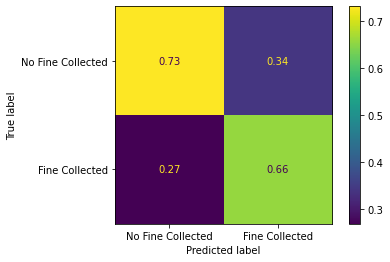

In [64]:
plot_confusion_matrix(rf_gs.best_estimator_, x_test, y_test, 
                      display_labels= ['No Fine Collected', 'Fine Collected'], normalize="pred");

# Part 5
# Visualizations
Since the training and testing dataset were split using the stratify method, we don't need to worry about drastic difference in data between the testing and training. I will use the cleaned training set to conduct visualization.

In [595]:
df = pd.read_csv("merged_train_df.csv", low_memory = False)
df = df.drop("Unnamed: 0", axis = 1)

df['Hearing Result'] = df['Hearing Result'].map({0: "NO FINE COLLECTED",
                                     1: "FINE COLLECTED"})

In [596]:
df["Hearing Result"].value_counts()

NO FINE COLLECTED    128802
FINE COLLECTED        84441
Name: Hearing Result, dtype: int64

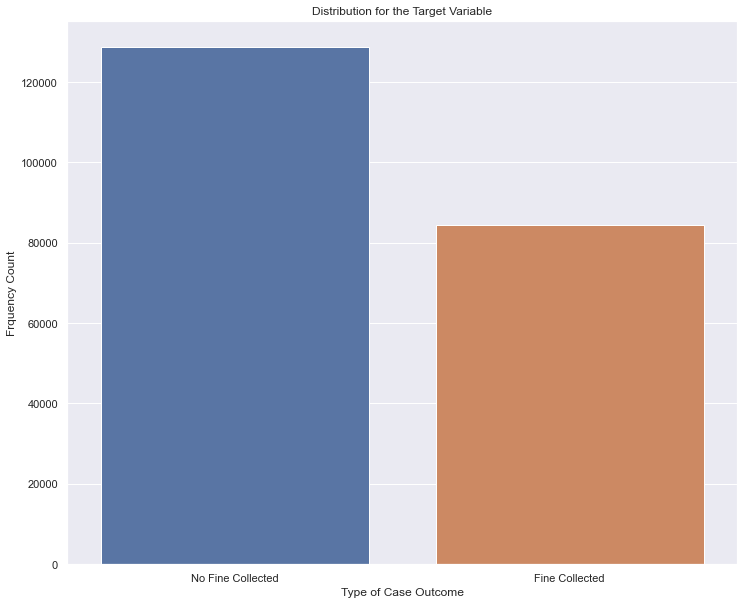

In [597]:
fig,axes = plt.subplots(figsize=(12,10))

sns.set_theme(style="darkgrid")
sns.countplot(x='Hearing Result', data=merged_train_df)
axes.set_title("Distribution for the Target Variable")
axes.set_xlabel("Type of Case Outcome")
axes.set_ylabel("Frquency Count")
axes.set(xticklabels=["No Fine Collected", "Fine Collected"])
fig.savefig("1target distribution.png")

In [598]:
step1 = df[df['Violation Location (Borough)'] != "NOT NYC"] 
step2 = pd.DataFrame(step1[step1['Violation Location (Borough)'] != "UNKNOWN"])

graph_2 = pd.DataFrame(pd.crosstab(step2['Violation Location (Borough)'], 
                 step2["Hearing Result"], normalize = "index"))

graph_2 = graph_2.sort_values(by = "NO FINE COLLECTED", ascending=True)
graph_2

Hearing Result,FINE COLLECTED,NO FINE COLLECTED
Violation Location (Borough),,
QUEENS,0.495002,0.504998
BROOKLYN,0.459972,0.540028
BRONX,0.405218,0.594782
MANHATTAN,0.304121,0.695879
STATEN IS,0.217526,0.782474


### How is the ratio for fine collected to no fine collected different for each borough?

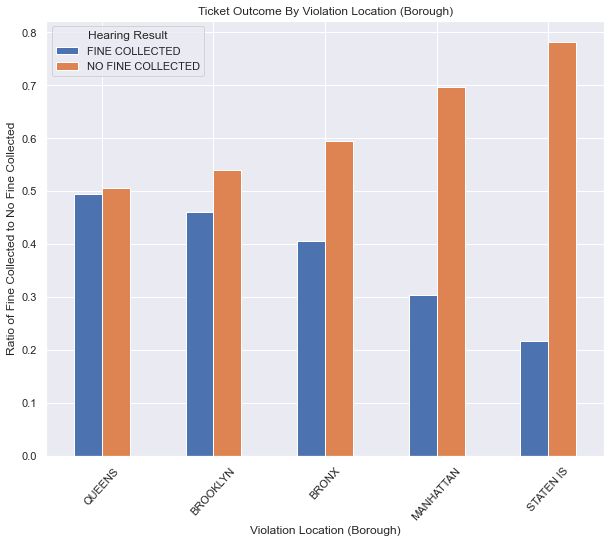

In [599]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = graph_2.plot.bar(ax=ax,)

plt.title('Ticket Outcome By Violation Location (Borough)')
plt.ylabel('Ratio of Fine Collected to No Fine Collected')
plt.xticks(rotation = 48)
plt.savefig("2ticketoutbyviolationlocation");

In [600]:
step1 = df[df['Respondent Address (Borough)'] != "NOT NYC"] 
step2 = pd.DataFrame(step1[step1['Respondent Address (Borough)'] != "UNKNOWN"])

graph_3 = pd.DataFrame(pd.crosstab(step2['Respondent Address (Borough)'], 
                 step2["Hearing Result"], normalize = "index"))

graph_3 = graph_3.sort_values(by = "NO FINE COLLECTED", ascending=True)
graph_3

Hearing Result,FINE COLLECTED,NO FINE COLLECTED
Respondent Address (Borough),,
BROOKLYN,0.427268,0.572732
QUEENS,0.409773,0.590227
BRONX,0.397267,0.602733
MANHATTAN,0.345796,0.654204
STATEN IS,0.233388,0.766612


### How is the ratio for fine collected to no fine collected different for each borough by respondent address?

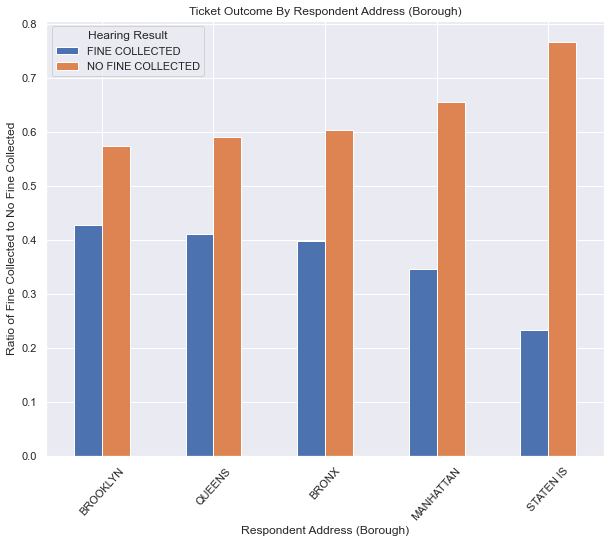

In [547]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = graph_3.plot.bar(ax=ax,)

plt.title('Ticket Outcome By Respondent Address (Borough)')
plt.ylabel('Ratio of Fine Collected to No Fine Collected')
plt.xticks(rotation = 48)
plt.savefig("3ticketoutbyrespondentaddress");

In [548]:
step1 = df[df['Issuing Agency'] != "NOT NYC"] 
step2 = pd.DataFrame(step1[step1['Issuing Agency'] != "UNKNOWN"])

graph_4 = pd.DataFrame(pd.crosstab(step2['Issuing Agency'], 
                 step2["Hearing Result"], normalize = "index"))

graph_4 = graph_4.sort_values(by = "NO FINE COLLECTED", ascending=True)
graph_4

Hearing Result,FINE COLLECTED,NO FINE COLLECTED
Issuing Agency,,
NYPD TRANSPORT INTELLIGENCE DI,0.664657,0.335343
SANITATION POLICE,0.458533,0.541467
NYPD (SEAGATE),0.421053,0.578947
NYPD,0.225488,0.774512


### How is the ratio for fine collected to no fine collected different for each issuing party?

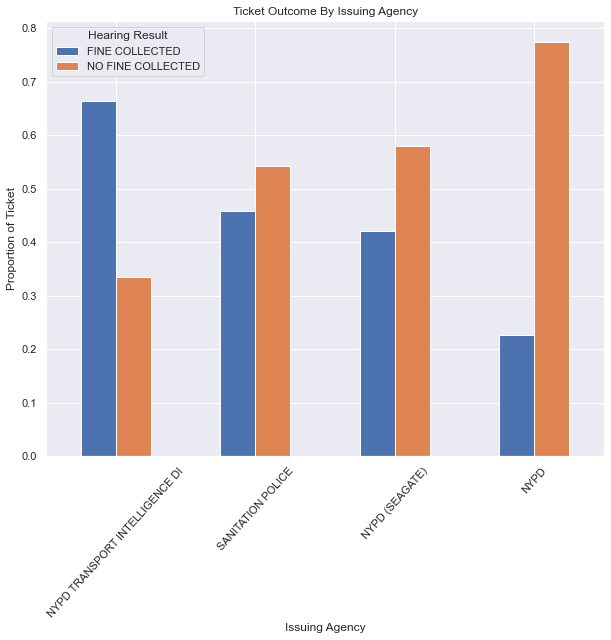

In [549]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = graph_4.plot.bar(ax=ax,)


plt.title('Ticket Outcome By Issuing Agency')
plt.ylabel('Proportion of Ticket')
plt.xticks(rotation = 48)
plt.savefig("4ticketoutbyissuingagency");

In [469]:
#select only the code sections selected by Random Forest

step1 = df[(df['Charge #1: Code Section'] == "AC 16") |
           
           (df['Charge #1: Code Section'] == "AC 17") |
          
           (df['Charge #1: Code Section'] == "AC 20") |
          
           (df['Charge #1: Code Section'] == "AC 10") ] 

step2 = pd.DataFrame(step1)

graph_5 = pd.DataFrame(pd.crosstab(step2['Charge #1: Code Section'], 
                 step2["Hearing Result"], normalize = "index"))

graph_5 = graph_5.sort_values(by = "NO FINE COLLECTED", ascending=True)
graph_5

Hearing Result,FINE COLLECTED,NO FINE COLLECTED
Charge #1: Code Section,,
AC 10,0.957219,0.042781
AC 16,0.453532,0.546468
AC 17,0.243050,0.756950
AC 20,0.160643,0.839357


### How is the ratio for fine collected to no fine collected different for each violation types?

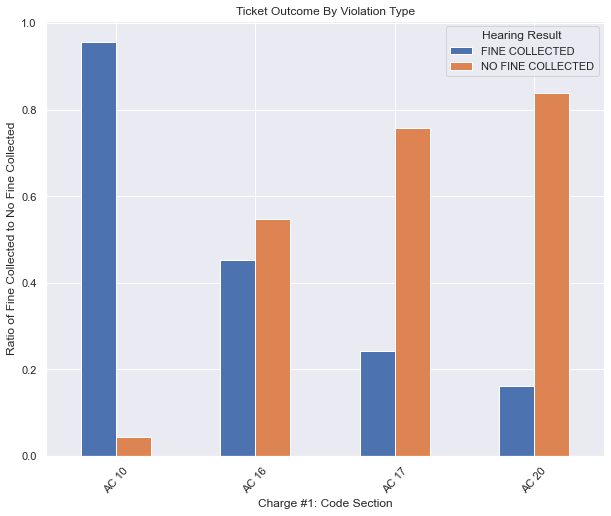

In [550]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = graph_5.plot.bar(ax=ax,)

plt.title('Ticket Outcome By Violation Type')
plt.ylabel('Ratio of Fine Collected to No Fine Collected')
plt.xticks(rotation = 48)
plt.savefig("5ticketoutbyviolationtype");

In [538]:
graph_6 = pd.DataFrame(pd.crosstab(df['Respondent Status'], 
                 df["Hearing Result"], normalize = False))

graph_6 = graph_6.sort_values(by = "NO FINE COLLECTED", ascending=True)
graph_6

Hearing Result,FINE COLLECTED,NO FINE COLLECTED
Respondent Status,,
Commercial,23200,19997
Person,61241,108805


### How is the ratio for fine collected to no fine collected different for respondent type?

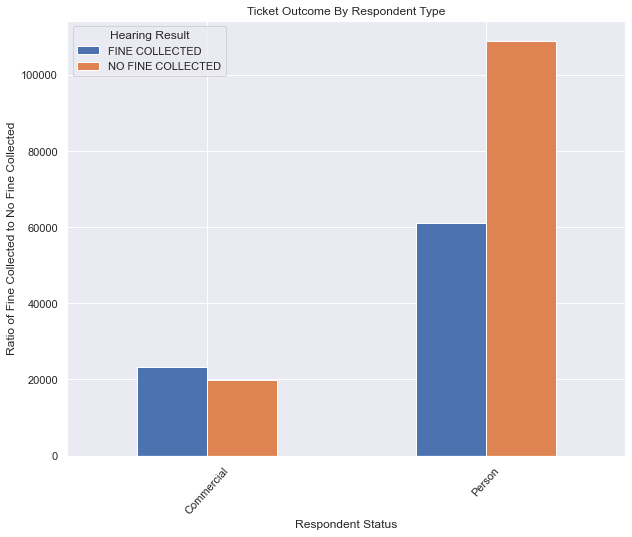

In [551]:
fig, ax = plt.subplots(figsize=(10, 8))

ax = graph_6.plot.bar(ax=ax,)

plt.title('Ticket Outcome By Respondent Type')
plt.ylabel('Ratio of Fine Collected to No Fine Collected')
plt.xticks(rotation = 48)
plt.savefig("6ticketoutbyrespondentype");

### What is going on with Staten Island?

In [104]:
df = pd.read_csv("merged_train_df.csv", low_memory = False)
df = df.drop("Unnamed: 0", axis = 1)

df['Hearing Result'] = df['Hearing Result'].map({0: "NO FINE COLLECTED",
                                     1: "FINE COLLECTED"})

In [105]:
SI_df = df[df["Violation Location (Borough)"] == "STATEN IS"]

In [150]:
counts_df = SI_df.groupby(["Hearing Result","Issuing Agency"])["Issuing Agency"].count().unstack()
counts_df

Issuing Agency,NYPD,NYPD TRANSPORT INTELLIGENCE DI,SANITATION POLICE,UNKNOWN
Hearing Result,,,,
FINE COLLECTED,116,29,1931,29
NO FINE COLLECTED,832,15,6712,13


In [145]:
NYPD = (116/(832+116))*100
NYPD

12.236286919831224

In [146]:
NYPDT = (29/(29+15))*100
NYPDT

65.9090909090909

In [147]:
Sanitation = (1931/(1931+6712))*100
Sanitation

22.341779474719424

In [149]:
UNKNOWN = (29/(29+13))*100
UNKNOWN

69.04761904761905

<AxesSubplot:xlabel='Hearing Result'>

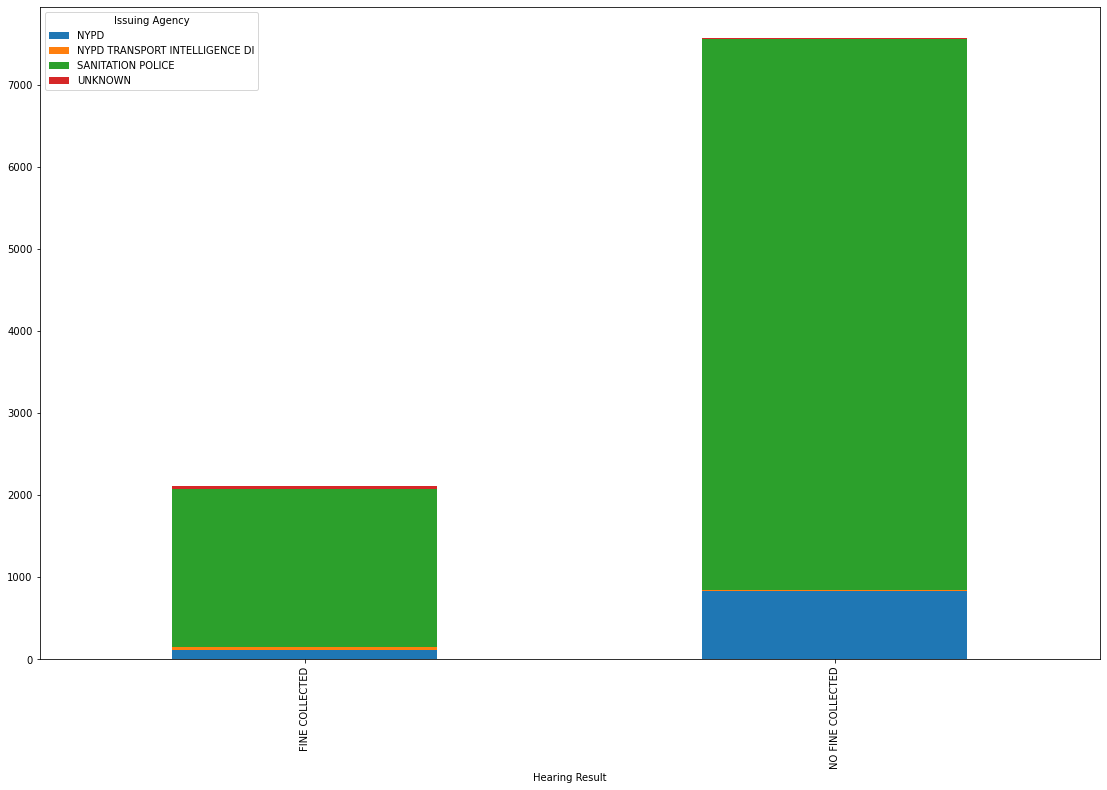

In [136]:
fig, ax = plt.subplots(figsize=(19, 12))

counts_df.plot(kind="bar", stacked=True, ax=ax)

In [151]:
#select only the code sections selected by Random Forest

step1 = SI_df[(SI_df['Charge #1: Code Section'] == "AC 16") |
           
           (SI_df['Charge #1: Code Section'] == "AC 17") |
          
           (SI_df['Charge #1: Code Section'] == "AC 20") |
          
           (SI_df['Charge #1: Code Section'] == "AC 10") ] 

step2 = pd.DataFrame(step1)

In [154]:
counts_df_code = step2.groupby(["Hearing Result","Charge #1: Code Section"])["Charge #1: Code Section"].count().unstack()
counts_df_code

Charge #1: Code Section,AC 10,AC 16,AC 17,AC 20
Hearing Result,,,,
FINE COLLECTED,52,1805,2,2
NO FINE COLLECTED,1,6030,3,8


<AxesSubplot:xlabel='Hearing Result'>

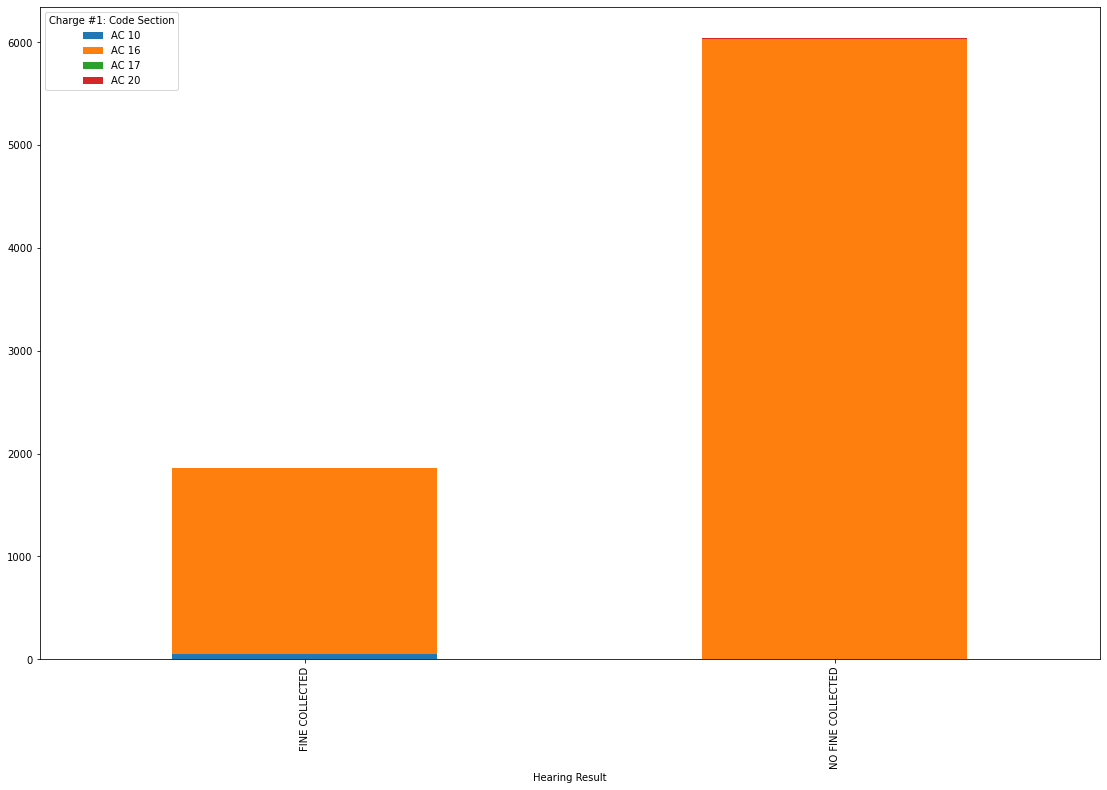

In [155]:
fig, ax = plt.subplots(figsize=(19, 12))

counts_df_code.plot(kind="bar", stacked=True, ax=ax)